In [65]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import copy
import os
import time
import sys
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns    
from mpl_toolkits.mplot3d import Axes3D



## Fonctions LSTM ##

In [66]:

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def lstm_cell_forward(xt, a_prev, c_prev, parameters):
    """
    Arguments:
    xt -- Données d'entrée à time-step t, array de forme (n_x, m)
    a_prev -- Etat caché précédent, array de forme (n_a, m)
    c_prev -- Etat de la cellule précédente, array de forme (n_a, m)
    parameters -- Dictionnaire Python contenant:
                Wf -- Poids de la forget gate, array de forme (n_a, n_a + n_x)
                bf -- Biais de la forget gate, array de forme (n_a, 1)
                Wi -- Poids de l'update gate, array de forme (n_a, n_a + n_x)
                bi -- Biais de l'update gate, array de forme (n_a, 1)
                Wc -- Poids de la première "tanh", array de forme (n_a, n_a + n_x)
                bc -- Biais de la première "tanh", array de forme (n_a, 1)
                Wo -- Poids de l'output gate, array de forme (n_a, n_a + n_x)
                bo -- Biais de l'output gate, array de forme (n_a, 1)
                Wy -- Poids pour l'état caché, array de forme (n_y, n_a)
                by -- Biais pour l'état caché, array de forme (n_y, 1)

    Returns:
    a_next -- Prochain état caché, array de forme (n_a, m)
    c_next -- Prochain état de cellule, array de forme (n_a, m)
    yt_pred -- Prédiction à time-step t, array de forme (n_y, m)
    cache -- Tuple de valeurs pour la backpropagation
    """

    # Récupérer les paramètres du dictionnaire
    Wf = parameters["Wf"]
    bf = parameters["bf"]
    Wi = parameters["Wi"]
    bi = parameters["bi"]
    Wc = parameters["Wc"]
    bc = parameters["bc"]
    Wo = parameters["Wo"]
    bo = parameters["bo"]
    Wy = parameters["Wy"]
    by = parameters["by"]

    # Récupérer les dimensions
    n_x, m = xt.shape
    n_y, n_a = Wy.shape

    # Concaténer a_prev et xt
    concat = np.zeros((n_a + n_x, m))
    concat[: n_a, :] = a_prev
    concat[n_a:, :] = xt

    # Calculer les valeurs pour ft, it, cct, c_next, ot, a_next
    ft = sigmoid(np.matmul(Wf, concat) + bf)
    it = sigmoid(np.matmul(Wi, concat) + bi)
    cct = np.tanh(np.matmul(Wc, concat) + bc)
    c_next = (ft * c_prev) + (it * cct)
    ot = sigmoid(np.matmul(Wo, concat) + bo)
    a_next = ot * np.tanh(c_next)

    # Calculer la prédiction
    yt_pred = softmax(np.matmul(Wy, a_next) + by)

    # Stocker les valeurs pour la backpropagation
    cache = (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters)

    return a_next, c_next, yt_pred, cache

def lstm_cell_backward(da_next, dc_next, cache):
    """
    Arguments:
    da_next -- Gradient du prochain état caché, array de forme (n_a, m)
    dc_next -- Gradient du prochain état de cellule, array de forme (n_a, m)
    cache -- Cache du forward pass

    Returns:
    gradients -- Dictionnaire contenant les gradients
    """

    # Récupérer les informations du cache
    (a_next, c_next, a_prev, c_prev, ft, it, cct, ot, xt, parameters) = cache

    # Récupérer les dimensions
    n_x, m = xt.shape
    n_a, m = a_next.shape

    # Calculer les dérivées des portes
    dot = da_next * np.tanh(c_next) * ot * (1 - ot)
    dcct = (dc_next * it + ot * (1 - np.square(np.tanh(c_next))) * it * da_next) * (1 - np.square(cct))
    dit = (dc_next * cct + ot * (1 - np.square(np.tanh(c_next))) * cct * da_next) * it * (1 - it)
    dft = (dc_next * c_prev + ot * (1 - np.square(np.tanh(c_next))) * c_prev * da_next) * ft * (1 - ft)

    concat = np.concatenate((a_prev, xt), axis=0)

    # Calculer les dérivées des paramètres
    dWf = np.dot(dft, concat.T)
    dWi = np.dot(dit, concat.T)
    dWc = np.dot(dcct, concat.T)
    dWo = np.dot(dot, concat.T)
    dbf = np.sum(dft, axis=1, keepdims=True)
    dbi = np.sum(dit, axis=1, keepdims=True)
    dbc = np.sum(dcct, axis=1, keepdims=True)
    dbo = np.sum(dot, axis=1, keepdims=True)

    # Calculer les dérivées par rapport à l'état caché précédent, l'état de cellule précédent et l'entrée
    da_prev = np.dot(parameters['Wf'][:, :n_a].T, dft) + np.dot(parameters['Wi'][:, :n_a].T, dit) + np.dot(
        parameters['Wc'][:, :n_a].T, dcct) + np.dot(parameters['Wo'][:, :n_a].T, dot)
    dc_prev = dc_next * ft + ot * (1 - np.square(np.tanh(c_next))) * ft * da_next
    dxt = np.dot(parameters['Wf'][:, n_a:].T, dft) + np.dot(parameters['Wi'][:, n_a:].T, dit) + np.dot(
        parameters['Wc'][:, n_a:].T, dcct) + np.dot(parameters['Wo'][:, n_a:].T, dot)

    # Sauvegarder les gradients
    gradients = {"dxt": dxt, "da_prev": da_prev, "dc_prev": dc_prev, "dWf": dWf, "dbf": dbf, "dWi": dWi, "dbi": dbi,
                 "dWc": dWc, "dbc": dbc, "dWo": dWo, "dbo": dbo}

    return gradients

def lstm_forward(x, a0, parameters):
    """
    Arguments:
    x -- Données d'entrée pour chaque time-step, array de forme (n_x, m, T_x)
    a0 -- État caché initial, array de forme (n_a, m)
    parameters -- Dictionnaire Python des paramètres LSTM

    Returns:
    a -- États cachés pour chaque time-step, array de forme (n_a, m, T_x)
    y -- Prédictions pour chaque time-step, array de forme (n_y, m, T_x)
    c -- États de cellule pour chaque time-step, array de forme (n_a, m, T_x)
    caches -- Tuple de valeurs pour la backpropagation
    """

    # Initialiser les caches
    caches = []

    # Récupérer les dimensions
    n_x, m, T_x = x.shape
    n_y, n_a = parameters["Wy"].shape

    # Initialiser a, c et y avec des zéros
    a = np.zeros((n_a, m, T_x))
    c = a.copy()
    y = np.zeros((n_y, m, T_x))

    # Initialiser a_next et c_next
    a_next = a0
    c_next = np.zeros(a_next.shape)

    # Boucle sur tous les time-steps
    for t in range(T_x):
        # Mettre à jour a_next, c_next, calculer la prédiction et obtenir le cache
        a_next, c_next, yt, cache = lstm_cell_forward(x[:, :, t], a_next, c_next, parameters)
        # Sauvegarder les valeurs
        a[:, :, t] = a_next
        y[:, :, t] = yt
        c[:, :, t] = c_next
        # Ajouter le cache
        caches.append(cache)

    # Stocker les valeurs pour la backpropagation
    caches = (caches, x)

    return a, y, c, caches

def lstm_backward(da, caches):
    """
    Arguments:
    da -- Gradient par rapport aux états cachés, array de forme (n_a, m, T_x)
    caches -- Cache du forward pass

    Returns:
    gradients -- Dictionnaire Python contenant les gradients
    """

    # Récupérer les valeurs du cache
    (caches, x) = caches
    (a1, c1, a0, c0, f1, i1, cc1, o1, x1, parameters) = caches[0]

    # Récupérer les dimensions
    n_a, m, T_x = da.shape
    n_x, m = x1.shape

    # Initialiser les gradients
    dx = np.zeros((n_x, m, T_x))
    da0 = np.zeros((n_a, m))
    da_prevt = np.zeros(da0.shape)
    dc_prevt = np.zeros(da0.shape)
    dWf = np.zeros((n_a, n_a + n_x))
    dWi = np.zeros(dWf.shape)
    dWc = np.zeros(dWf.shape)
    dWo = np.zeros(dWf.shape)
    dbf = np.zeros((n_a, 1))
    dbi = np.zeros(dbf.shape)
    dbc = np.zeros(dbf.shape)
    dbo = np.zeros(dbf.shape)

    # Boucle sur la séquence en sens inverse
    for t in reversed(range(T_x)):
        # Calculer tous les gradients à l'aide de lstm_cell_backward
        gradients = lstm_cell_backward(da[:, :, t] + da_prevt, dc_prevt, caches[t])
        # Stocker ou ajouter les gradients aux gradients de l'étape précédente
        dx[:, :, t] = gradients["dxt"]
        dWf += gradients["dWf"]
        dWi += gradients["dWi"]
        dWc += gradients["dWc"]
        dWo += gradients["dWo"]
        dbf += gradients["dbf"]
        dbi += gradients["dbi"]
        dbc += gradients["dbc"]
        dbo += gradients["dbo"]
        da_prevt = gradients["da_prev"]
        dc_prevt = gradients["dc_prev"]

    # Définir le premier gradient d'activation
    da0 = gradients["da_prev"]

    # Stocker les gradients dans un dictionnaire Python
    gradients = {"dx": dx, "da0": da0, "dWf": dWf, "dbf": dbf, "dWi": dWi, "dbi": dbi,
                 "dWc": dWc, "dbc": dbc, "dWo": dWo, "dbo": dbo}

    return gradients

def initialize_adam_for_lstm(parameters):
    """
    Initialise v et s pour les paramètres du LSTM.

    Arguments:
    parameters -- Dictionnaire Python contenant les paramètres du LSTM.

    Returns:
    v -- Dictionnaire Python qui contiendra la moyenne mobile exponentielle du gradient.
    s -- Dictionnaire Python qui contiendra la moyenne mobile exponentielle du carré du gradient.
    """
    v = {}
    s = {}

    # Initialiser v, s pour tous les paramètres du LSTM
    for key in parameters.keys():
        v["d" + key] = np.zeros_like(parameters[key])
        s["d" + key] = np.zeros_like(parameters[key])

    return v, s

def update_parameters_with_adam_for_lstm(parameters, grads, v, s, t, learning_rate=0.01,
                                         beta1=0.9, beta2=0.999, epsilon=1e-8):

    v_corrected = {}  # Estimation du premier moment corrigée du biais
    s_corrected = {}  # Estimation du second moment corrigée du biais

    # Effectuer la mise à jour Adam sur tous les paramètres
    for key in parameters.keys():
        # Clé correspondante dans les dictionnaires grads, v, s
        d_key = "d" + key

        # S'assurer que nous avons le gradient correspondant
        if d_key not in grads:
            continue

        # Moyenne mobile des gradients
        v[d_key] = beta1 * v[d_key] + (1 - beta1) * grads[d_key]

        # Calcul de l'estimation du premier moment corrigée du biais
        v_corrected[d_key] = v[d_key] / (1 - beta1**t)

        # Moyenne mobile des carrés des gradients
        s[d_key] = beta2 * s[d_key] + (1 - beta2) * (grads[d_key]**2)

        # Calcul de l'estimation du second moment corrigée du biais
        s_corrected[d_key] = s[d_key] / (1 - beta2**t)

        # Mise à jour des paramètres
        parameters[key] = parameters[key] - learning_rate * v_corrected[d_key] / (np.sqrt(s_corrected[d_key]) + epsilon)

    return parameters, v, s

def initialize_lstm_parameters(n_a, n_x, n_y):
    """
    Initialise les paramètres du LSTM.

    Arguments:
    n_a -- nombre d'unités dans la couche cachée
    n_x -- taille d'entrée
    n_y -- taille de sortie

    Returns:
    parameters -- dictionnaire Python contenant les paramètres initialisés
    """
    np.random.seed(1)

    # Initialisation avec He/Xavier
    Wf = np.random.randn(n_a, n_a + n_x) * np.sqrt(1. / (n_a + n_x))
    bf = np.zeros((n_a, 1))
    Wi = np.random.randn(n_a, n_a + n_x) * np.sqrt(1. / (n_a + n_x))
    bi = np.zeros((n_a, 1))
    Wc = np.random.randn(n_a, n_a + n_x) * np.sqrt(1. / (n_a + n_x))
    bc = np.zeros((n_a, 1))
    Wo = np.random.randn(n_a, n_a + n_x) * np.sqrt(1. / (n_a + n_x))
    bo = np.zeros((n_a, 1))
    Wy = np.random.randn(n_y, n_a) * np.sqrt(1. / n_a)
    by = np.zeros((n_y, 1))

    parameters = {"Wf": Wf, "bf": bf, "Wi": Wi, "bi": bi, "Wc": Wc, "bc": bc, "Wo": Wo, "bo": bo, "Wy": Wy, "by": by}

    return parameters

def train_lstm(X_train, Y_train, n_a, n_x, n_y, num_epochs=10, seed=1, learning_rate=0.01, initial_params=None):
    """
    Entraîne un LSTM sur les données fournies, avec possibilité d'initialiser avec des paramètres existants.

    Arguments:
    X_train -- données d'entrée, numpy array de forme (n_x, m, T_x)
    Y_train -- étiquettes, numpy array de forme (n_y, m, T_x)
    n_a -- nombre d'unités dans la couche cachée
    n_x -- taille d'entrée
    n_y -- taille de sortie
    num_epochs -- nombre d'époques d'entraînement
    seed -- graine pour la reproductibilité
    learning_rate -- taux d'apprentissage
    initial_params -- paramètres initiaux (optionnel)

    Returns:
    parameters -- paramètres finaux
    parameters_history -- historique des paramètres à chaque époque
    loss_history -- historique des pertes
    """
    np.random.seed(seed)

    # Initialisation des paramètres
    if initial_params is None:
        parameters = initialize_lstm_parameters(n_a, n_x, n_y)
    else:
        parameters = copy.deepcopy(initial_params)

    parameters_history = []
    loss_history = []

    # Initialiser Adam
    v, s = initialize_adam_for_lstm(parameters)
    t = 0  # Compteur pour Adam

    for epoch in range(num_epochs):
        print(f"Époque {epoch+1}/{num_epochs}")

        # Forward pass
        a0 = np.zeros((n_a, X_train.shape[1]))
        a, y_pred, c, caches = lstm_forward(X_train, a0, parameters)

        # Calcul de la perte (cross-entropy)
        loss = -np.sum(Y_train * np.log(y_pred + 1e-8)) / (Y_train.shape[1] * Y_train.shape[2])
        loss_history.append(loss)
        print(f"Loss: {loss:.4f}")

        # Initialisation du gradient de sortie
        da = np.zeros_like(a)

        # Créer un dictionnaire complet pour les gradients
        gradients = {}

        # Pour chaque pas de temps, calculer le gradient
        dWy = np.zeros_like(parameters["Wy"])
        dby = np.zeros_like(parameters["by"])

        for t_idx in range(Y_train.shape[2]):
            # Gradient de la cross-entropy
            dy = y_pred[:, :, t_idx] - Y_train[:, :, t_idx]
            # Accumuler les gradients pour Wy et by
            dWy += np.dot(dy, a[:, :, t_idx].T)
            dby += np.sum(dy, axis=1, keepdims=True)
            # Gradient par rapport à a
            da[:, :, t_idx] = np.dot(parameters["Wy"].T, dy)

        # Backward pass pour le reste des paramètres LSTM
        lstm_gradients = lstm_backward(da, caches)

        # Combiner tous les gradients
        gradients = lstm_gradients.copy()
        gradients["dWy"] = dWy
        gradients["dby"] = dby

        # Mise à jour des paramètres avec Adam
        t += 1
        parameters, v, s = update_parameters_with_adam_for_lstm(parameters, gradients, v, s, t, learning_rate)

        # Sauvegarde des paramètres après cette époque
        parameters_history.append(copy.deepcopy(parameters))

    return parameters, parameters_history, loss_history

## Fonctions de Clustering ##

## Clustering à la Diane ##

In [67]:
def cluster_parameters_with_consistent_labels(parameters_history, n_clusters=3, 
                                             similarity_threshold=10, local_clustering=False):
    """
    Clusterise les paramètres à chaque époque en maintenant la cohérence des labels entre les époques.
    
    Arguments:
    parameters_history -- liste de dictionnaires ou liste de listes de dictionnaires contenant les paramètres
    n_clusters -- nombre de clusters à former
    similarity_threshold -- seuil de similarité pour considérer des clusters comme équivalents
    local_clustering -- si True, effectue une clusterisation par client/seed
    
    Returns:
    global_cluster_labels -- étiquettes de cluster global pour chaque graine à chaque époque
    flat_params -- paramètres aplatis pour chaque graine à chaque époque
    param_shapes -- formes des paramètres
    param_sizes -- tailles des paramètres aplatis
    all_centroids -- tous les centres de clusters uniques
    centroid_labels -- étiquettes globales de chaque centroïde
    """
    if local_clustering:
        # Dans le cas local, parameters_history est une liste par client/seed
        n_seeds = len(parameters_history)
        n_epochs = len(parameters_history[0])
    else:
        # Dans le cas global, parameters_history est déjà aplati par seed
        n_seeds = len(parameters_history)
        n_epochs = len(parameters_history[0])

    # Structures pour stocker les résultats
    global_cluster_labels = np.zeros((n_seeds, n_epochs), dtype=int)
    flat_params = []
    all_centroids = []  # Liste de tous les centres de cluster uniques trouvés
    centroid_labels = []  # Étiquette globale pour chaque centroïde
    next_global_label = 0  # Pour attribuer des étiquettes globales uniques

    # Obtenir les formes et tailles des paramètres
    _, param_shapes, param_sizes = flatten_parameters(
        parameters_history[0][0] if local_clustering else parameters_history[0][0]
    )

    # Aplatir les paramètres pour toutes les graines et époques
    for seed in range(n_seeds):
        seed_params = []
        for epoch in range(n_epochs):
            flattened, _, _ = flatten_parameters(
                parameters_history[seed][epoch] if local_clustering else parameters_history[seed][epoch]
            )
            seed_params.append(flattened)
        flat_params.append(seed_params)

    flat_params = np.array(flat_params)

    # Clusteriser par époque
    for epoch in range(n_epochs):
        epoch_params = flat_params[:, epoch, :]
        
        # Vérifier et remplacer les NaN avant clustering
        if np.isnan(epoch_params).any():
            print(f"NaN trouvés dans les paramètres à l'époque {epoch}, remplacement par zéros")
            epoch_params = np.nan_to_num(epoch_params, nan=0.0)
            
        kmeans = KMeans(n_clusters=min(n_clusters, n_seeds), random_state=42, n_init=10)
        local_clusters = kmeans.fit_predict(epoch_params)
        local_centroids = kmeans.cluster_centers_

        # Si c'est la première époque, initialiser les centroïdes globaux
        if epoch == 0:
            all_centroids = local_centroids.copy()
            centroid_labels = list(range(len(local_centroids)))
            next_global_label = len(local_centroids)
            global_cluster_labels[:, epoch] = local_clusters
        else:
            # Pour chaque centroïde local, trouver le centroïde global le plus proche
            n_local_clusters = len(local_centroids)
            global_clusters_map = np.zeros(n_local_clusters, dtype=int)

            for i in range(n_local_clusters):
                local_centroid = local_centroids[i].reshape(1, -1)

                # Calculer les distances avec tous les centroïdes globaux connus
                distances = np.array([np.linalg.norm(local_centroid - centroid.reshape(1, -1)) 
                                     for centroid in all_centroids])

                # Trouver le centroïde global le plus proche
                closest_idx = np.argmin(distances)
                min_distance = distances[closest_idx]

                # Si la distance est inférieure au seuil, utiliser l'étiquette existante
                if min_distance < similarity_threshold:
                    global_clusters_map[i] = centroid_labels[closest_idx]
                else:
                    # Sinon, créer une nouvelle étiquette globale
                    global_clusters_map[i] = next_global_label
                    all_centroids = np.vstack([all_centroids, local_centroid])
                    centroid_labels.append(next_global_label)
                    next_global_label += 1

            # Remplacer les étiquettes locales par les étiquettes globales
            global_labels = np.array([global_clusters_map[c] for c in local_clusters])
            global_cluster_labels[:, epoch] = global_labels
            
            # Afficher la distribution des clusters pour cette époque
            unique_clusters, counts = np.unique(global_labels, return_counts=True)
            print(f"\nDistribution des clusters pour l'époque {epoch}:")
            for cluster, count in zip(unique_clusters, counts):
                print(f"  Cluster {cluster}: {count} instances")
            print(f"Nombre total de clusters uniques jusqu'à présent: {next_global_label}")

    return global_cluster_labels, flat_params, param_shapes, param_sizes, all_centroids, centroid_labels

def cluster_local_by_client_single_consistent(client_seeds_history, n_clusters, similarity_threshold=10):
    """
    Version améliorée de cluster_local_by_client_single avec cohérence des labels entre époques
    
    Arguments:
    client_seeds_history -- liste de listes de dictionnaires Python contenant les paramètres
    n_clusters -- nombre de clusters à former
    similarity_threshold -- seuil de similarité pour considérer des clusters comme équivalents
    
    Returns:
    cluster_centers -- centres des clusters
    transition_matrix -- matrice de transition
    """
    n_seeds = len(client_seeds_history)
    n_epochs = len(client_seeds_history[0])

    # Obtenir les formes et tailles des paramètres
    _, param_shapes, param_sizes = flatten_parameters(client_seeds_history[0][0])

    # Aplatir les paramètres pour toutes les graines et époques
    flat_params = []
    for seed in range(n_seeds):
        seed_params = []
        for epoch in range(n_epochs):
            flattened, _, _ = flatten_parameters(client_seeds_history[seed][epoch])
            seed_params.append(flattened)
        flat_params.append(seed_params)

    flat_params = np.array(flat_params)
    
    # Structure pour stocker les étiquettes de cluster global
    global_cluster_labels = np.zeros((n_seeds, n_epochs), dtype=int)
    
    # Tous les centres de clusters uniques trouvés
    all_centroids = []  
    # Étiquette globale pour chaque centroïde
    centroid_labels = []  
    # Pour attribuer des étiquettes globales uniques
    next_global_label = 0  

    # Clusteriser par époque
    for epoch in range(n_epochs):
        epoch_params = flat_params[:, epoch, :]
        
        # Vérifier et remplacer les NaN avant clustering
        if np.isnan(epoch_params).any():
            print(f"NaN trouvés dans les paramètres à l'époque {epoch}, remplacement par zéros")
            epoch_params = np.nan_to_num(epoch_params, nan=0.0)
            
        kmeans = KMeans(n_clusters=min(n_clusters, n_seeds), random_state=42, n_init=10)
        local_clusters = kmeans.fit_predict(epoch_params)
        local_centroids = kmeans.cluster_centers_

        # Si c'est la première époque, initialiser les centroïdes globaux
        if epoch == 0:
            all_centroids = local_centroids.copy()
            centroid_labels = list(range(len(local_centroids)))
            next_global_label = len(local_centroids)
            global_cluster_labels[:, epoch] = local_clusters
        else:
            # Pour chaque centroïde local, trouver le centroïde global le plus proche
            n_local_clusters = len(local_centroids)
            global_clusters_map = np.zeros(n_local_clusters, dtype=int)

            for i in range(n_local_clusters):
                local_centroid = local_centroids[i].reshape(1, -1)

                # Calculer les distances avec tous les centroïdes globaux connus
                distances = np.array([np.linalg.norm(local_centroid - centroid.reshape(1, -1)) 
                                     for centroid in all_centroids])

                # Trouver le centroïde global le plus proche
                closest_idx = np.argmin(distances)
                min_distance = distances[closest_idx]

                # Si la distance est inférieure au seuil, utiliser l'étiquette existante
                if min_distance < similarity_threshold:
                    global_clusters_map[i] = centroid_labels[closest_idx]
                else:
                    # Sinon, créer une nouvelle étiquette globale
                    global_clusters_map[i] = next_global_label
                    all_centroids = np.vstack([all_centroids, local_centroid])
                    centroid_labels.append(next_global_label)
                    next_global_label += 1

            # Remplacer les étiquettes locales par les étiquettes globales
            global_labels = np.array([global_clusters_map[c] for c in local_clusters])
            global_cluster_labels[:, epoch] = global_labels
    
    # Calculer la matrice de transition
    transition_matrix = np.zeros((n_clusters, n_clusters))
    total_by_from_cluster = np.zeros(n_clusters)

    # Compter les transitions
    for seed in range(n_seeds):
        for epoch in range(n_epochs - 1):
            from_cluster = global_cluster_labels[seed, epoch]
            to_cluster = global_cluster_labels[seed, epoch + 1]
            if from_cluster < n_clusters and to_cluster < n_clusters:
                transition_matrix[from_cluster, to_cluster] += 1
                total_by_from_cluster[from_cluster] += 1

    # Normaliser pour obtenir les probabilités
    for i in range(n_clusters):
        row_sum = total_by_from_cluster[i]
        if row_sum > 0:
            transition_matrix[i] = transition_matrix[i] / row_sum
        else:
            # Si aucune transition n'est observée depuis ce cluster, distribution uniforme
            transition_matrix[i] = 1.0 / n_clusters

    # Utiliser les centres les plus récents s'ils sont disponibles
    # (sinon utiliser tous ceux qui ont été identifiés)
    last_kmeans_centers = local_centroids
    
    # Si le nombre de centres est inférieur à n_clusters, ajouter des centres supplémentaires
    if len(last_kmeans_centers) < n_clusters:
        # Ajouter des centres aléatoires
        print(f"Attention: Seulement {len(last_kmeans_centers)} centres trouvés, ajout de centres supplémentaires")
        if len(all_centroids) >= n_clusters:
            cluster_centers = all_centroids[:n_clusters]
        else:
            # Créer des centres aléatoires pour compléter
            missing_centers = n_clusters - len(last_kmeans_centers)
            # Générer des centres aléatoires dans le même espace que les données
            min_vals = np.min(flat_params, axis=(0, 1))
            max_vals = np.max(flat_params, axis=(0, 1))
            random_centers = np.random.uniform(min_vals, max_vals, (missing_centers, flat_params.shape[2]))
            cluster_centers = np.vstack([last_kmeans_centers, random_centers])
    else:
        cluster_centers = last_kmeans_centers[:n_clusters]

    return cluster_centers, transition_matrix

def cluster_local_by_client_single(client_seeds_history, n_clusters):
    """
    Version simplifiée de cluster_local_by_client pour un seul client.
    Maintient l'interface originale pour la compatibilité.
    
    Arguments:
    client_seeds_history -- liste de listes de dictionnaires Python contenant les paramètres
    n_clusters -- nombre de clusters à former
    
    Returns:
    cluster_centers -- centres des clusters
    transition_matrix -- matrice de transition
    """
    # Utiliser notre nouvelle version avec cohérence des labels
    return cluster_local_by_client_single_consistent(client_seeds_history, n_clusters)

def cluster_local_by_client(parameters_history_by_client, n_clusters=3, n_steps=None):
    """
    Effectue une clusterisation locale pour chaque client
    
    Arguments:
    parameters_history_by_client -- dictionnaire contenant les historiques de paramètres pour chaque client
    n_clusters -- nombre de clusters à former pour chaque client
    n_steps -- nombre d'étapes à simuler (par défaut: même que la longueur d'origine)
    
    Returns:
    client_clusters -- liste des centres de clusters et matrices de transition pour chaque client
    param_shapes -- formes des paramètres
    param_sizes -- tailles des paramètres
    """
    n_clients = len(parameters_history_by_client)
    client_clusters = []
    
    # Pour stocker les formes et tailles des paramètres (identiques pour tous les clients)
    param_shapes = None
    param_sizes = None
    
    for client_id in range(n_clients):
        client_params_history = parameters_history_by_client[client_id]
        
        # Clusteriser les paramètres locaux du client
        cluster_centers, transition_matrix = cluster_local_by_client_single_consistent(
            client_params_history, n_clusters=n_clusters)
        
        # Conserver les formes et tailles des paramètres (identiques pour tous les clients)
        if client_id == 0:
            _, param_shapes, param_sizes = flatten_parameters(client_params_history[0][0])
        
        # Stocker les centres et la matrice pour ce client
        client_clusters.append((cluster_centers, transition_matrix))
    
    return client_clusters, param_shapes, param_sizes

def cluster_trajectories_with_existing_centers(client_seeds_history, cluster_centers):
    """
    Attribue des clusters aux trajectoires en utilisant des centres préexistants.
    Maintient l'interface originale pour la compatibilité.
    
    Arguments:
    client_seeds_history -- liste d'historiques de paramètres pour différentes seeds
    cluster_centers -- centres des clusters préétablis
    
    Returns:
    flat_labels -- étiquettes de cluster pour chaque seed à chaque époque
    """
    n_seeds = len(client_seeds_history)
    n_epochs = len(client_seeds_history[0])
    
    # Initialiser les étiquettes de cluster
    flat_labels = np.zeros((n_seeds, n_epochs), dtype=int)
    
    # Pour chaque graine et chaque époque
    for seed in range(n_seeds):
        for epoch in range(n_epochs):
            # Aplatir les paramètres de cette époque
            flattened, _, _ = flatten_parameters(client_seeds_history[seed][epoch])
            
            # Calculer les distances aux centres des clusters
            distances = np.array([np.linalg.norm(flattened - center) for center in cluster_centers])
            
            # Trouver le centre le plus proche et attribuer le cluster
            flat_labels[seed, epoch] = np.argmin(distances)
    
    return flat_labels

def update_cluster_centers(client_cluster_centers, client_seeds_history, learning_rate=0.05):
    """
    Met à jour les centres de clusters basés sur les nouvelles trajectoires d'entraînement.
    Maintient l'interface originale pour la compatibilité.
    
    Arguments:
    client_cluster_centers -- centres de clusters actuels
    client_seeds_history -- nouvelles trajectoires d'entraînement
    learning_rate -- taux d'apprentissage pour la mise à jour
    
    Returns:
    updated_centers -- centres de clusters mis à jour
    """
    updated_centers = []
    
    for client_id, (centers, client_history) in enumerate(zip(client_cluster_centers, client_seeds_history)):
        n_clusters = centers.shape[0]
        
        # Aplatir les dernières trajectoires d'entraînement
        flat_trajectories = []
        for seed_history in client_history:
            # Prendre le dernier état des paramètres
            flattened, _, _ = flatten_parameters(seed_history[-1])
            flat_trajectories.append(flattened)
        
        flat_trajectories = np.array(flat_trajectories)
        
        # Assigner ces nouvelles trajectoires aux clusters existants
        assignments = np.zeros(len(flat_trajectories), dtype=int)
        for i, trajectory in enumerate(flat_trajectories):
            # Trouver le centre le plus proche
            distances = [np.linalg.norm(trajectory - center) for center in centers]
            assignments[i] = np.argmin(distances)
        
        # Mettre à jour les centres
        new_centers = np.array(centers)
        for cluster_idx in range(n_clusters):
            cluster_points = flat_trajectories[assignments == cluster_idx]
            if len(cluster_points) > 0:
                # Moyenne des points dans le cluster
                cluster_mean = np.mean(cluster_points, axis=0)
                # Mise à jour progressive du centre
                new_centers[cluster_idx] = (1 - learning_rate) * centers[cluster_idx] + learning_rate * cluster_mean
        
        updated_centers.append(new_centers)
    
    return updated_centers

def visualize_transition_matrices_local(final_transition_matrices, n_clients=3):
    """
    Visualise les matrices de transition finales pour chaque client.
    
    Arguments:
    final_transition_matrices -- liste des matrices de transition finales
    n_clients -- nombre de clients
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import numpy as np
    
    n_matrices = len(final_transition_matrices)
    matrices_per_client = n_matrices // n_clients
    
    fig, axes = plt.subplots(n_clients, 1, figsize=(15, 5 * n_clients))
    if n_clients == 1:
        axes = [axes]
    
    for client_id in range(n_clients):
        start_idx = client_id * matrices_per_client
        end_idx = (client_id + 1) * matrices_per_client
        
        # Calculer la matrice moyenne pour ce client
        client_matrices = final_transition_matrices[start_idx:end_idx]
        if not client_matrices:
            continue
            
        avg_matrix = np.mean(client_matrices, axis=0)
        
        # Identifier les lignes et colonnes non nulles
        non_zero_rows = np.where(np.sum(avg_matrix, axis=1) > 0)[0]
        non_zero_cols = np.where(np.sum(avg_matrix, axis=0) > 0)[0]
        
        # Si aucune ligne/colonne non nulle, passer au client suivant
        if len(non_zero_rows) == 0 or len(non_zero_cols) == 0:
            continue
            
        # Extraire la sous-matrice non nulle
        reduced_matrix = avg_matrix[np.ix_(non_zero_rows, non_zero_cols)]
        
        # Normaliser les lignes
        row_sums = np.sum(reduced_matrix, axis=1, keepdims=True)
        non_zero_rows_idx = np.where(row_sums > 0)[0]
        if len(non_zero_rows_idx) > 0:
            reduced_matrix[non_zero_rows_idx] = reduced_matrix[non_zero_rows_idx] / row_sums[non_zero_rows_idx]
        
        # Créer un DataFrame pandas pour la heatmap
        df = pd.DataFrame(
            reduced_matrix,
            index=[f'Cluster {c}' for c in non_zero_rows],
            columns=[f'Cluster {c}' for c in non_zero_cols]
        )
        
        # Tracer la heatmap
        sns.heatmap(df, annot=True, cmap='Blues', fmt='.2f', ax=axes[client_id], vmin=0, vmax=1)
        axes[client_id].set_title(f'Matrice de transition moyenne pour le client {client_id+1}')
        axes[client_id].set_xlabel('Cluster de destination')
        axes[client_id].set_ylabel('Cluster de départ')
    
    plt.tight_layout()
    plt.savefig('transition_matrices_local.png')
    plt.show()
    
    return fig

def update_with_transition_matrices_improved(client_transition_matrices, client_cluster_centers, 
                                          prev_global_params, param_shapes, param_sizes, n_clients, 
                                          learning_rate=0.1):
    """
    Met à jour le modèle global en utilisant les matrices de transition tout en intégrant l'historique.
    Maintient l'interface originale pour la compatibilité.
    
    Arguments et retours comme dans l'original.
    """
    # Calcul des nouveaux paramètres selon la méthode actuelle
    aggregated_params_flat = np.zeros_like(client_cluster_centers[0][0])
    
    # Pour chaque client
    for client_id in range(n_clients):
        transition_matrix = client_transition_matrices[client_id]
        cluster_centers = client_cluster_centers[client_id]
        n_clusters = transition_matrix.shape[0]
        
        # Calcul de la distribution stationnaire
        pi = np.ones(n_clusters) / n_clusters
        for _ in range(100):
            pi_new = np.dot(pi, transition_matrix)
            if np.allclose(pi, pi_new):
                break
            pi = pi_new
        
        # Pondérer les centres par la distribution stationnaire
        client_params_flat = np.zeros_like(cluster_centers[0])
        for i in range(n_clusters):
            client_params_flat += pi[i] * cluster_centers[i]
        
        # Contribution de ce client
        aggregated_params_flat += client_params_flat / n_clients
    
    # Obtenir les paramètres précédents sous forme aplatie
    prev_params_flat, _, _ = flatten_parameters(prev_global_params)
    
    # Combiner les anciens et nouveaux paramètres (comme un momentum)
    combined_params_flat = (1 - learning_rate) * prev_params_flat + learning_rate * aggregated_params_flat
    
    # Reconstruire les paramètres finaux
    updated_global_params = unflatten_parameters(combined_params_flat, param_shapes, param_sizes)
    
    return updated_global_params

def visualize_communication_rounds_comparison(communication_results):
    """
    Visualise les résultats des cycles de communication.
    
    Arguments:
    communication_results -- liste des résultats pour chaque cycle
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Extraire les données
    cycles = [r['cycle'] for r in communication_results]
    proposed_acc = [r['proposed_accuracy'] for r in communication_results]
    fedavg_acc = [r['fedavg_accuracy'] for r in communication_results]
    proposed_loss = [r['proposed_loss'] for r in communication_results]
    fedavg_loss = [r['fedavg_loss'] for r in communication_results]
    traditional_bw = [r['traditional_bandwidth']/1024 for r in communication_results]  # en KB
    proposed_bw = [r['proposed_bandwidth']/1024 for r in communication_results]  # en KB
    
    # Calculer les économies de bande passante
    bandwidth_savings = [(1 - p/t)*100 if t > 0 else 0 for p, t in zip(proposed_bw, traditional_bw)]
    
    # Créer les visualisations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Précision
    axes[0, 0].plot(cycles, proposed_acc, 'o-', color='blue', label='Méthode proposée')
    axes[0, 0].plot(cycles, fedavg_acc, 's--', color='red', label='FedAvg traditionnel')
    axes[0, 0].set_xlabel('Cycle de communication')
    axes[0, 0].set_ylabel('Précision')
    axes[0, 0].set_title('Évolution de la précision')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Perte
    axes[0, 1].plot(cycles, proposed_loss, 'o-', color='blue', label='Méthode proposée')
    axes[0, 1].plot(cycles, fedavg_loss, 's--', color='red', label='FedAvg traditionnel')
    axes[0, 1].set_xlabel('Cycle de communication')
    axes[0, 1].set_ylabel('Perte')
    axes[0, 1].set_title('Évolution de la perte')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Bande passante
    axes[1, 0].bar(np.array(cycles) - 0.2, traditional_bw, width=0.4, color='red', label='FedAvg traditionnel')
    axes[1, 0].bar(np.array(cycles) + 0.2, proposed_bw, width=0.4, color='blue', label='Méthode proposée')
    axes[1, 0].set_xlabel('Cycle de communication')
    axes[1, 0].set_ylabel('Bande passante (KB)')
    axes[1, 0].set_title('Consommation de bande passante')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Économie de bande passante
    axes[1, 1].bar(cycles, bandwidth_savings, color='green')
    axes[1, 1].set_xlabel('Cycle de communication')
    axes[1, 1].set_ylabel('Économie (%)')
    axes[1, 1].set_title('Économie de bande passante')
    axes[1, 1].grid(alpha=0.3)
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(bandwidth_savings):
        if cycles[i] > 0:  # Seulement pour les cycles > 0 (pas d'économie au premier cycle)
            axes[1, 1].text(i, v + 1, f"{v:.1f}%", ha='center')
    
    plt.tight_layout()
    plt.savefig('communication_rounds_comparison.png')
    plt.show()
    
    return fig

## Fonctions utilitaires ##

In [68]:
def flatten_parameters(parameters):
    """
    Aplatit les paramètres d'un LSTM en un seul vecteur.

    Arguments:
    parameters -- dictionnaire Python contenant les paramètres

    Returns:
    flattened -- vecteur aplati des paramètres
    param_shapes -- formes originales des paramètres
    param_sizes -- tailles des paramètres aplatis
    """
    flattened = []
    param_shapes = {}
    param_sizes = {}

    for key in ["Wf", "bf", "Wi", "bi", "Wc", "bc", "Wo", "bo", "Wy", "by"]:
        param = parameters[key]
        param_shapes[key] = param.shape
        flattened.append(param.flatten())
        param_sizes[key] = param.size

    return np.concatenate(flattened), param_shapes, param_sizes

def unflatten_parameters(flattened, param_shapes, param_sizes):
    """
    Restaure un vecteur aplati de paramètres à leur forme originale.

    Arguments:
    flattened -- vecteur aplati des paramètres
    param_shapes -- formes originales des paramètres
    param_sizes -- tailles des paramètres aplatis

    Returns:
    parameters -- dictionnaire Python contenant les paramètres
    """
    parameters = {}
    start = 0

    for key in ["Wf", "bf", "Wi", "bi", "Wc", "bc", "Wo", "bo", "Wy", "by"]:
        size = param_sizes[key]
        parameters[key] = flattened[start:start+size].reshape(param_shapes[key])
        start += size

    return parameters

def calculate_transmission_size(parameters=None, n_clusters=None, transition_matrix=None, client_centers=None):
    """
    Calcule la taille de transmission en octets.

    Args:
        parameters: Dictionnaire ou liste des paramètres originaux (arrays numpy)
        n_clusters: Nombre de clusters utilisés
        transition_matrix: Matrice de transition entre clusters
        client_centers: Centres des clusters par client (liste de tuples (centers, transition_matrix))

    Returns:
        Taille totale en octets
    """
    total_size = 0

    # Cas 1: Paramètres originaux (dictionnaire)
    if parameters is not None and isinstance(parameters, dict):
        for key in parameters:
            if hasattr(parameters[key], 'size'):
                # Chaque nombre flottant occupe 4 octets (float32)
                total_size += parameters[key].size * 4
        return total_size

    # Cas 2: Paramètres originaux (liste)
    elif parameters is not None and isinstance(parameters, list) and all(hasattr(p, 'size') for p in parameters if p is not None):
        for param in parameters:
            if param is not None and hasattr(param, 'size'):
                # Chaque nombre flottant occupe 4 octets (float32)
                total_size += param.size * 4
        return total_size

    # Cas 3: Clusterisation globale avec n_clusters et transition_matrix
    elif n_clusters is not None and transition_matrix is not None:
        # Taille de la matrice de transition
        if hasattr(transition_matrix, 'size'):
            total_size += transition_matrix.size * 4

        # Si nous avons des centres de clusters explicites
        if client_centers is not None and not isinstance(client_centers, list):
            if hasattr(client_centers, 'size'):
                total_size += client_centers.size * 4

        return total_size

    # Cas 4: Clusterisation locale avec client_centers
    elif client_centers is not None and isinstance(client_centers, list):
        for client_data in client_centers:
            # Dans la clusterisation locale, client_data est un tuple (cluster_centers, transition_matrix)
            if isinstance(client_data, tuple) and len(client_data) == 2:
                centers, trans_matrix = client_data

                # Taille des centres de clusters
                if hasattr(centers, 'size'):
                    total_size += centers.size * 4

                # Taille de la matrice de transition
                if hasattr(trans_matrix, 'size'):
                    total_size += trans_matrix.size * 4

        return total_size

    # En cas d'erreur ou de paramètres non valides
    raise ValueError("Entrée invalide pour le calcul de la taille de transmission")

def aggregate_client_clusters(client_clusters, param_shapes, param_sizes, n_clients, weight_by_client=None):
    """
    Agrège les clusters de paramètres de plusieurs clients

    Arguments:
    client_clusters -- liste des centres de clusters et matrices de transition pour chaque client
    param_shapes -- formes des paramètres
    param_sizes -- tailles des paramètres
    n_clients -- nombre de clients
    weight_by_client -- poids pour l'agrégation de chaque client (optionnel)

    Returns:
    aggregated_params -- paramètres agrégés à partir des clusters des clients
    """
    # Si les poids ne sont pas fournis, utiliser un poids uniforme
    if weight_by_client is None:
        weight_by_client = np.ones(n_clients) / n_clients

    # Initialiser les paramètres agrégés
    all_flattened_params = []

    # Pour chaque client, simuler une trajectoire à partir de ses clusters
    for client_id, (cluster_centers, transition_matrix) in enumerate(client_clusters):
        # Choisir un cluster de départ (utiliser le cluster le plus fréquent ou le premier)
        initial_cluster = 0

        # Obtenir un ensemble de paramètres représentatifs de ce client
        # Simplement moyenne des centres de clusters pondérée par la probabilité stationnaire
        n_clusters = transition_matrix.shape[0]

        # Calculer la distribution stationnaire (au lieu de simuler une trajectoire)
        # Méthode simple: itérer la matrice de transition jusqu'à convergence
        pi = np.ones(n_clusters) / n_clusters  # Distribution initiale uniforme
        for _ in range(100):  # Nombre d'itérations arbitraire, devrait converger rapidement
            pi_new = np.dot(pi, transition_matrix)
            if np.allclose(pi, pi_new):
                break
            pi = pi_new

        # Pondérer les centres par la distribution stationnaire
        client_params = np.zeros_like(cluster_centers[0])
        for i in range(n_clusters):
            client_params += pi[i] * cluster_centers[i]

        # Ajouter à la liste des paramètres aplatis
        all_flattened_params.append(client_params)

    # Combiner tous les paramètres avec les poids des clients
    aggregated_flattened = np.zeros_like(all_flattened_params[0])
    for client_id, flattened in enumerate(all_flattened_params):
        aggregated_flattened += weight_by_client[client_id] * flattened

    # Reconstruire les paramètres à leur forme d'origine
    aggregated_params = unflatten_parameters(aggregated_flattened, param_shapes, param_sizes)

    return aggregated_params

def update_with_transition_matrices(client_transition_matrices, global_kmeans_model, initial_global_params, param_shapes, param_sizes):
    """
    Met à jour le modèle global en utilisant uniquement les matrices de transition des clients.

    Arguments:
    client_transition_matrices -- liste des matrices de transition de chaque client
    global_kmeans_model -- modèle KMeans global utilisé pour la clusterisation
    initial_global_params -- paramètres initiaux obtenus par FedAvg
    param_shapes -- formes des paramètres
    param_sizes -- tailles des paramètres aplatis

    Returns:
    updated_global_params -- paramètres globaux mis à jour
    """
    n_clients = len(client_transition_matrices)
    n_clusters = global_kmeans_model.cluster_centers_.shape[0]

    # Agréger les matrices de transition des clients
    global_transition_matrix = np.zeros((n_clusters, n_clusters))
    for client_id in range(n_clients):
        global_transition_matrix += client_transition_matrices[client_id]

    # Normaliser la matrice de transition globale
    for i in range(n_clusters):
        row_sum = np.sum(global_transition_matrix[i])
        if row_sum > 0:
            global_transition_matrix[i] = global_transition_matrix[i] / row_sum
        else:
            global_transition_matrix[i] = np.ones(n_clusters) / n_clusters

    # Calculer la distribution stationnaire de la matrice de transition
    pi = np.ones(n_clusters) / n_clusters  # Distribution initiale uniforme
    for _ in range(100):  # Nombre d'itérations arbitraire pour convergence
        pi_new = np.dot(pi, global_transition_matrix)
        if np.allclose(pi, pi_new):
            break
        pi = pi_new

    # Créer le nouveau modèle global en pondérant les centres par la distribution stationnaire
    weighted_centers = np.zeros_like(global_kmeans_model.cluster_centers_[0])
    for i in range(n_clusters):
        weighted_centers += pi[i] * global_kmeans_model.cluster_centers_[i]

    # Convertir les paramètres aplatis en structure de dictionnaire
    updated_global_params = unflatten_parameters(weighted_centers, param_shapes, param_sizes)

    return updated_global_params



## Fonctions de données ##

In [69]:
weather_switerland_month_1 = pd.read_csv('Switzerland\weather_switerland_month1.csv')
weather_switerland_month_2 = pd.read_csv('Switzerland\weather_switerland_month2.csv')
weather_switerland_month_3 = pd.read_csv('Switzerland\weather_switerland_month3.csv')
weather_switerland_month_4 = pd.read_csv('Switzerland\weather_switerland_month4.csv')
weather_switerland_month_5 = pd.read_csv('Switzerland\weather_switerland_month5.csv')
weather_switerland_month_6 = pd.read_csv('Switzerland\weather_switerland_month6.csv')
weather_switerland_month_7 = pd.read_csv('Switzerland\weather_switerland_month7.csv')
weather_switerland_month_8 = pd.read_csv('Switzerland\weather_switerland_month8.csv')
weather_switerland_month_9 = pd.read_csv('Switzerland\weather_switerland_month9.csv')
weather_switerland_month_10 = pd.read_csv('Switzerland\weather_switerland_month10.csv')
weather_switerland_month_11 = pd.read_csv('Switzerland\weather_switerland_month11.csv')
weather_switerland_month_12 = pd.read_csv('Switzerland\weather_switerland_month12.csv')


In [70]:
weather_norway_month_1 = pd.read_csv('Norway\weather_norway_month1.csv')
weather_norway_month_2 = pd.read_csv('Norway\weather_norway_month2.csv')
weather_norway_month_3 = pd.read_csv('Norway\weather_norway_month3.csv')
weather_norway_month_4 = pd.read_csv('Norway\weather_norway_month4.csv')
weather_norway_month_5 = pd.read_csv('Norway\weather_norway_month5.csv')
weather_norway_month_6 = pd.read_csv('Norway\weather_norway_month6.csv')
weather_norway_month_7 = pd.read_csv('Norway\weather_norway_month7.csv')
weather_norway_month_8 = pd.read_csv('Norway\weather_norway_month8.csv')
weather_norway_month_9 = pd.read_csv('Norway\weather_norway_month9.csv')
weather_norway_month_10 = pd.read_csv('Norway\weather_norway_month10.csv')
weather_norway_month_11 = pd.read_csv('Norway\weather_norway_month11.csv')
weather_norway_month_12 = pd.read_csv('Norway\weather_norway_month12.csv')


In [71]:
weather_estonia_month_1 = pd.read_csv('Estonia\weather_estonia_month1.csv')
weather_estonia_month_2 = pd.read_csv('Estonia\weather_estonia_month2.csv')
weather_estonia_month_3 = pd.read_csv('Estonia\weather_estonia_month3.csv')
weather_estonia_month_4 = pd.read_csv('Estonia\weather_estonia_month4.csv')
weather_estonia_month_5 = pd.read_csv('Estonia\weather_estonia_month5.csv')
weather_estonia_month_6 = pd.read_csv('Estonia\weather_estonia_month6.csv')
weather_estonia_month_7 = pd.read_csv('Estonia\weather_estonia_month7.csv')
weather_estonia_month_8 = pd.read_csv('Estonia\weather_estonia_month8.csv')
weather_estonia_month_9 = pd.read_csv('Estonia\weather_estonia_month9.csv')
weather_estonia_month_10 = pd.read_csv('Estonia\weather_estonia_month10.csv')
weather_estonia_month_11 = pd.read_csv('Estonia\weather_estonia_month11.csv')
weather_estonia_month_12 = pd.read_csv('Estonia\weather_estonia_month12.csv')


In [72]:
def generate_realistic_consumption(weather_df, country):
    # Créer une série temporelle pour la consommation
    consumption = np.zeros(len(weather_df))
    
    # Base de consommation par pays (MW)
    base_consumption = {
        "Switzerland": 6000,
        "Norway": 8000,
        "Estonia": 2000
    }
    base = base_consumption.get(country, 5000)
    
    # Facteurs d'influence
    for i in range(len(weather_df)):
        # Heure de la journée (cycle quotidien)
        hour = pd.to_datetime(weather_df['datetime'].iloc[i]).hour
        day_factor = 1.0 + 0.2 * np.sin((hour - 8) * np.pi / 12)  # Pic à 8h et 20h
        
        # Température (plus il fait froid, plus la consommation est élevée)
        temp = weather_df['temp'].iloc[i]
        temp_factor = 1.0 + max(0, (15 - temp) / 15)  # Augmente quand temp < 15°C
        
        # Vent (plus il y a de vent, plus la consommation est élevée - chauffage)
        wind = weather_df['windspeed'].iloc[i]
        wind_factor = 1.0 + wind / 50  # Effet modéré
        
        # Visibilité/nuages (plus il fait sombre, plus l'éclairage est utilisé)
        cloud = weather_df['cloudcover'].iloc[i] if 'cloudcover' in weather_df else 50
        cloud_factor = 1.0 + cloud / 200  # Effet faible
        
        # Jour de la semaine (weekend vs jour ouvrable)
        weekday = pd.to_datetime(weather_df['datetime'].iloc[i]).weekday()
        weekday_factor = 0.9 if weekday >= 5 else 1.0  # Baisse le weekend
        
        # Calculer la consommation pour cette heure
        consumption[i] = base * day_factor * temp_factor * wind_factor * cloud_factor * weekday_factor
        
        # Ajouter un bruit aléatoire (±5%)
        consumption[i] *= np.random.uniform(0.95, 1.05)
    
    return pd.DataFrame({'Consumption': consumption})

def load_real_data(n_clients, n_seeds_per_client, n_x, n_y, sequence_length):
    """
    Charge les données réelles des pays depuis leur structure de dossiers.
    """
    import os
    import pandas as pd
    import numpy as np
    from sklearn.preprocessing import StandardScaler
    
    # Répertoire de travail
    current_dir = os.getcwd()
    print(f"Répertoire de travail actuel: {current_dir}")
    print(f"Contenu du répertoire: {os.listdir()}")
    
    # Liste des pays disponibles (dossiers)
    countries = ["Switzerland", "Norway", "Estonia"]
    available_countries = []
    
    # Vérifier quels pays ont des données
    for country in countries:
        if os.path.exists(country) and os.path.isdir(country):
            files = os.listdir(country)
            csv_files = [f for f in files if f.endswith('.csv')]
            if csv_files:
                available_countries.append(country)
                print(f"Pays {country} trouvé avec {len(csv_files)} fichiers CSV")
            else:
                print(f"Aucun fichier CSV trouvé pour {country}")
        else:
            print(f"Dossier {country} introuvable")
    
    if not available_countries:
        raise ValueError("Aucun fichier de données météo trouvé pour les pays spécifiés.")
    
    print(f"Pays disponibles: {available_countries}")
    
    # Limiter le nombre de clients aux pays disponibles
    n_clients = min(n_clients, len(available_countries))
    clients_data = []
    
    for client_id in range(n_clients):
        country = available_countries[client_id]
        client_seeds_data = []
        
        print(f"Chargement des données pour {country} (client {client_id+1})...")
        
        # Charger les données météo pour ce pays
        weather_data = []
        csv_files = [f for f in os.listdir(country) if f.endswith('.csv')]
        
        for file_name in csv_files:
            file_path = os.path.join(country, file_name)
            try:
                df_month = pd.read_csv(file_path)
                weather_data.append(df_month)
                print(f"Chargé {file_name}, {df_month.shape[0]} lignes")
            except Exception as e:
                print(f"Erreur lors du chargement de {file_path}: {e}")
        
        if not weather_data:
            print(f"Aucune donnée n'a pu être chargée pour {country}. Ce client sera ignoré.")
            continue
        
        # Concaténer les données météo
        weather_df = pd.concat(weather_data, ignore_index=True)
        print(f"Données chargées pour {country}: {len(weather_df)} enregistrements")
        print(f"Colonnes disponibles: {weather_df.columns.tolist()}")
        
        # Générer des données de consommation
        consumption_df = generate_consumption_from_weather(weather_df, country)
        
        # Vérifier et préparer les données
        if 'datetime' not in weather_df.columns:
            weather_df['datetime'] = pd.date_range(start='2023-01-01', periods=len(weather_df), freq='H')
        
        # Sélectionner les features
        features = select_weather_features(weather_df, n_x)
        print(f"Features sélectionnées pour {country}: {features}")
        
        # Préparer les données
        X_data = weather_df[features].values
        Y_data = consumption_df['Consumption'].values.reshape(-1, 1)
        
        # Normaliser
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()
        X_normalized = scaler_X.fit_transform(X_data)
        Y_normalized = scaler_Y.fit_transform(Y_data)
        
        # Pour chaque seed, créer différentes séquences d'entraînement
        for seed in range(n_seeds_per_client):
            # Créer des séquences
            X_sequences, Y_sequences = create_sequences(
                X_normalized, Y_normalized, sequence_length, offset=seed
            )
            
            if len(X_sequences) == 0:
                print(f"Pas assez de données pour créer des séquences avec la seed {seed}")
                continue
                
            # Reformater pour LSTM (n_x, batch_size, sequence_length)
            X_train_lstm = np.transpose(X_sequences, (2, 0, 1))  # (n_x, batch_size, sequence_length)
            Y_train_lstm = np.transpose(Y_sequences, (1, 0, 2))  # (n_y, batch_size, sequence_length)
            
            client_seeds_data.append((X_train_lstm, Y_train_lstm))
        
        if client_seeds_data:
            clients_data.append(client_seeds_data)
        else:
            print(f"Aucune séquence valide n'a pu être créée pour {country}")
    
    if not clients_data:
        raise ValueError("Aucune donnée n'a pu être chargée pour aucun client")
    
    return clients_data

def generate_consumption_from_weather(weather_df, country):
    """
    Génère des données de consommation réalistes basées sur les données météorologiques.
    
    Arguments:
    weather_df -- DataFrame pandas contenant les données météo
    country -- nom du pays pour adapter les facteurs de consommation
    
    Returns:
    consumption_df -- DataFrame pandas contenant une colonne 'Consumption'
    """
    # Facteurs spécifiques par pays
    country_factors = {
        "Switzerland": {"base": 6000, "temp_factor": 1.0, "day_factor": 1.0},
        "Norway": {"base": 8000, "temp_factor": 1.2, "day_factor": 0.9},
        "Estonia": {"base": 3000, "temp_factor": 1.1, "day_factor": 0.95}
    }
    
    factors = country_factors.get(country, {"base": 5000, "temp_factor": 1.0, "day_factor": 1.0})
    
    # Vérifier la disponibilité des colonnes nécessaires
    datetime_col = None
    for col in ["datetime", "date", "time"]:
        if col in weather_df.columns:
            datetime_col = col
            break
    
    if not datetime_col:
        # Créer une colonne datetime si absente
        weather_df["datetime"] = pd.date_range(start="2023-01-01", periods=len(weather_df), freq="H")
        datetime_col = "datetime"
    
    # Convertir datetime en objet datetime si ce n'est pas déjà le cas
    if not pd.api.types.is_datetime64_any_dtype(weather_df[datetime_col]):
        try:
            weather_df[datetime_col] = pd.to_datetime(weather_df[datetime_col])
        except:
            # Si conversion impossible, créer une nouvelle colonne
            weather_df["datetime"] = pd.date_range(start="2023-01-01", periods=len(weather_df), freq="H")
            datetime_col = "datetime"
    
    # Extraire l'heure du jour et le jour de la semaine
    hours = weather_df[datetime_col].dt.hour
    weekdays = weather_df[datetime_col].dt.dayofweek
    
    # Identifier les colonnes pertinentes
    temp_col = next((col for col in weather_df.columns if col in ["temp", "temperature"]), None)
    humidity_col = next((col for col in weather_df.columns if "humid" in col.lower()), None)
    wind_col = next((col for col in weather_df.columns if "wind" in col.lower() and "dir" not in col.lower()), None)
    cloud_col = next((col for col in weather_df.columns if "cloud" in col.lower()), None)
    
    # Générer la consommation
    consumption = np.zeros(len(weather_df))
    
    for i in range(len(weather_df)):
        # Base de consommation
        base = factors["base"]
        
        # Effet de l'heure (pic matin et soir)
        hour = hours[i]
        hour_factor = 1.0 + 0.3 * np.sin((hour - 8) * np.pi / 12) * factors["day_factor"]
        
        # Effet du jour de la semaine (baisse le weekend)
        weekday = weekdays[i]
        weekday_factor = 0.8 if weekday >= 5 else 1.0
        
        # Effet de la température
        temp_effect = 1.0
        if temp_col:
            temp = weather_df[temp_col].iloc[i]
            temp_effect = 1.0 + factors["temp_factor"] * max(0, (15 - temp) / 20)
        
        # Effets supplémentaires si disponibles
        additional_factor = 1.0
        
        if wind_col:
            wind = weather_df[wind_col].iloc[i]
            additional_factor *= 1.0 + wind / 100
        
        if humidity_col:
            humidity = weather_df[humidity_col].iloc[i]
            additional_factor *= 1.0 + humidity / 500
        
        if cloud_col:
            cloud = weather_df[cloud_col].iloc[i]
            additional_factor *= 1.0 + cloud / 300
        
        # Calculer la consommation finale avec bruit aléatoire
        consumption[i] = base * hour_factor * weekday_factor * temp_effect * additional_factor
        consumption[i] *= np.random.uniform(0.95, 1.05)  # Ajouter 5% de bruit aléatoire
    
    return pd.DataFrame({"Consumption": consumption})

def select_weather_features(weather_df, n_x):
    """
    Sélectionne les n_x meilleures features météorologiques pour l'entrée du modèle.
    
    Arguments:
    weather_df -- DataFrame pandas avec les données météo
    n_x -- nombre de features à sélectionner
    
    Returns:
    selected_features -- liste des noms de colonnes sélectionnées
    """
    # Liste des features par ordre de priorité
    priority_features = [
        "temp", "feelslike", "humidity", "windspeed", "dew",
        "precip", "cloudcover", "visibility", "solarradiation", 
        "solarenergy", "uvindex", "windgust", "sealevelpressure",
        "snowdepth", "precipprob"
    ]
    
    # Colonnes à exclure
    exclude_cols = ["name", "datetime", "date", "time", "preciptype", 
                    "stations", "icon", "conditions", "severerisk",
                    "winddir", "snow", "Consumption"]
    
    # Trouver les features disponibles dans le DataFrame
    available_features = []
    
    # D'abord essayer les features prioritaires
    for feature in priority_features:
        if feature in weather_df.columns and feature not in exclude_cols:
            available_features.append(feature)
    
    # Si pas assez, ajouter d'autres colonnes numériques
    if len(available_features) < n_x:
        numeric_cols = weather_df.select_dtypes(include=np.number).columns
        for col in numeric_cols:
            if col not in available_features and col not in exclude_cols:
                available_features.append(col)
    
    # Limiter au nombre demandé
    selected_features = available_features[:n_x]
    
    # S'il n'y a toujours pas assez de features, lever une erreur
    if len(selected_features) < n_x:
        raise ValueError(f"Pas assez de features disponibles: {len(selected_features)} < {n_x}")
    
    return selected_features

def create_test_dataset(clients_data, batch_size, n_x, n_y, sequence_length):
    """
    Crée un jeu de données de test en utilisant une partie des données de chaque client.
    """
    test_samples_X = []
    test_samples_Y = []

    for client_id, client_seeds_data in enumerate(clients_data):
        # Vérifier la structure des données
        print(f"Structure des données pour le client {client_id}:")
        print(f"Type: {type(client_seeds_data)}")
        
        # Si c'est un tuple, c'est directement (X, Y)
        if isinstance(client_seeds_data, tuple) and len(client_seeds_data) == 2:
            X, Y = client_seeds_data
            print(f"Forme de X: {X.shape}, Forme de Y: {Y.shape}")
        # Si c'est une liste, c'est une liste de seeds, prendre la première
        elif isinstance(client_seeds_data, list) and len(client_seeds_data) > 0:
            if isinstance(client_seeds_data[0], tuple) and len(client_seeds_data[0]) == 2:
                X, Y = client_seeds_data[0]
                print(f"Forme de X: {X.shape}, Forme de Y: {Y.shape}")
            else:
                print(f"Structure inattendue pour client_seeds_data[0]: {type(client_seeds_data[0])}")
                continue
        else:
            print(f"Structure inattendue pour client_seeds_data: {type(client_seeds_data)}")
            continue
        
        # Nombre d'échantillons à utiliser pour le test
        n_samples = X.shape[1]
        n_test = min(batch_size // len(clients_data), n_samples // 3)  # Environ 1/3 des données
        
        # Sélectionner les échantillons de test
        X_test = X[:, :n_test, :]
        Y_test = Y[:, :n_test, :]
        
        test_samples_X.append(X_test)
        test_samples_Y.append(Y_test)
    
    if not test_samples_X:
        raise ValueError("Aucun échantillon de test n'a pu être extrait.")
    
    # Concaténer les échantillons
    X_test = np.concatenate(test_samples_X, axis=1)
    Y_test = np.concatenate(test_samples_Y, axis=1)
    
    # S'assurer que la taille du batch est correcte
    if X_test.shape[1] > batch_size:
        X_test = X_test[:, :batch_size, :]
        Y_test = Y_test[:, :batch_size, :]
    
    print(f"Forme finale de X_test: {X_test.shape}, Y_test: {Y_test.shape}")
    return X_test, Y_test

def create_sequences(X, Y, sequence_length, offset=0):
    """
    Crée des séquences temporelles à partir des données X et Y.
    
    Arguments:
    X -- données d'entrée, numpy array de forme (n_features, n_samples)
    Y -- données cibles, numpy array de forme (n_targets, n_samples)
    sequence_length -- longueur de chaque séquence
    offset -- décalage pour commencer les séquences (défaut: 0)
    
    Returns:
    X_sequences -- séquences d'entrée, numpy array de forme (n_samples - sequence_length - offset + 1, sequence_length, n_features)
    Y_sequences -- séquences cibles, numpy array de forme (n_samples - sequence_length - offset + 1, n_targets, sequence_length)
    """
    n_samples = X.shape[0]
    
    # Vérifier s'il y a suffisamment d'échantillons pour créer au moins une séquence
    if n_samples < sequence_length + offset:
        return np.array([]), np.array([])
    
    # Nombre de séquences qui seront créées
    n_sequences = n_samples - sequence_length - offset + 1
    
    # Initialiser les tableaux de sortie
    X_sequences = []
    Y_sequences = []
    
    # Créer les séquences
    for i in range(n_sequences):
        start_idx = i + offset
        end_idx = start_idx + sequence_length
        
        # Extraire les séquences X et Y
        X_seq = X[start_idx:end_idx, :]
        Y_seq = Y[start_idx:end_idx, :]
        
        X_sequences.append(X_seq)
        Y_sequences.append(Y_seq)
    
    # Convertir en tableaux numpy
    X_sequences = np.array(X_sequences)
    Y_sequences = np.array(Y_sequences)
    
    return X_sequences, Y_sequences
    """
    Crée un jeu de données de test en utilisant une partie des données de chaque client.
    """
    test_samples_X = []
    test_samples_Y = []

    for client_id, client_seeds_data in enumerate(clients_data):
        # Prendre la première seed
        X, Y = client_seeds_data[0]
        
        # Nombre d'échantillons à utiliser pour le test
        n_samples = X.shape[1]
        n_test = min(batch_size // len(clients_data), n_samples // 3)  # Environ 1/3 des données
        
        # Sélectionner les échantillons de test
        X_test = X[:, :n_test, :]
        Y_test = Y[:, :n_test, :]
        
        test_samples_X.append(X_test)
        test_samples_Y.append(Y_test)
    
    # Concaténer les échantillons
    X_test = np.concatenate(test_samples_X, axis=1)
    Y_test = np.concatenate(test_samples_Y, axis=1)
    
    # S'assurer que la taille du batch est correcte
    if X_test.shape[1] > batch_size:
        X_test = X_test[:, :batch_size, :]
        Y_test = Y_test[:, :batch_size, :]
    
    return X_test, Y_test
    """
    Crée un jeu de données de test à partir des mêmes fichiers.
    Utilise les 30% réservés pour le test.
    
    Arguments:
    clients_data -- liste des données clients (non utilisée directement)
    batch_size -- taille du batch pour le test
    n_x -- dimension d'entrée
    n_y -- dimension de sortie
    sequence_length -- longueur de la séquence temporelle
    
    Returns:
    X_test -- données de test (n_x, batch_size, sequence_length)
    Y_test -- étiquettes de test (n_y, batch_size, sequence_length)
    """
    countries = ["Switzerland", "Norway", "Estonia"]
    test_samples_X = []
    test_samples_Y = []
    
    # Récupérer les pays disponibles
    available_countries = []
    for country in countries:
        file_prefix = "weather_switerland_month" if country == "Switzerland" else f"weather_{country.lower()}_month"
        country_files = [f for f in os.listdir() if f.startswith(file_prefix)]
        if country_files:
            available_countries.append(country)
    
    if not available_countries:
        raise ValueError("Aucun fichier de données météo trouvé pour les pays spécifiés.")
    
    for country in available_countries:
        # Charger les données météo pour ce pays
        weather_data = []
        file_prefix = "weather_switerland_month" if country == "Switzerland" else f"weather_{country.lower()}_month"
        
        for month in range(1, 13):
            file_name = f"{file_prefix}{month}.csv"
            
            try:
                if os.path.exists(file_name):
                    df_month = pd.read_csv(file_name)
                    weather_data.append(df_month)
            except Exception as e:
                print(f"Erreur lors du chargement de {file_name}: {e}")
        
        if not weather_data:
            continue
        
        # Concaténer les données météo
        weather_df = pd.concat(weather_data, ignore_index=True)
        
        # Générer des données de consommation
        consumption_df = generate_consumption_from_weather(weather_df, country)
        
        # Sélectionner les features
        features = select_weather_features(weather_df, n_x)
        
        # Préparer les données X et Y
        X_data = weather_df[features].values
        Y_data = consumption_df.values
        
        # Normaliser
        scaler_X = StandardScaler()
        scaler_Y = StandardScaler()
        X_normalized = scaler_X.fit_transform(X_data)
        Y_normalized = scaler_Y.fit_transform(Y_data)
        
        # Diviser - ne prendre que les 30% de test
        _, X_test, _, Y_test = train_test_split(
            X_normalized, Y_normalized, test_size=0.3, random_state=42
        )
        
        # Créer des séquences
        X_sequences, Y_sequences = create_sequences(X_test, Y_test, sequence_length)
        
        if len(X_sequences) == 0:
            continue
            
        # Reformater pour LSTM
        X_test_lstm = np.transpose(X_sequences, (2, 0, 1))
        Y_test_lstm = np.transpose(Y_sequences, (1, 0, 2))
        
        # Limiter le nombre d'échantillons pour ce pays
        max_samples = batch_size // len(available_countries)
        if X_test_lstm.shape[1] > max_samples:
            X_test_lstm = X_test_lstm[:, :max_samples, :]
            Y_test_lstm = Y_test_lstm[:, :max_samples, :]
        
        test_samples_X.append(X_test_lstm)
        test_samples_Y.append(Y_test_lstm)
    
    if not test_samples_X:
        raise ValueError("Aucune donnée de test n'a pu être préparée")
    
    # Concaténer les échantillons
    X_test = np.concatenate(test_samples_X, axis=1)
    Y_test = np.concatenate(test_samples_Y, axis=1)
    
    # Ajuster la taille du batch si nécessaire
    if X_test.shape[1] > batch_size:
        X_test = X_test[:, :batch_size, :]
        Y_test = Y_test[:, :batch_size, :]
    
    return X_test, Y_test

    """
    Crée un jeu de données de test à partir d'une fraction des données de chaque client.

    Arguments:
    clients_data -- données de tous les clients
    batch_size -- taille du batch pour le test
    n_x -- dimension d'entrée
    n_y -- dimension de sortie
    sequence_length -- longueur de la séquence temporelle

    Returns:
    X_test -- données de test, array de forme (n_x, batch_size, sequence_length)
    Y_test -- étiquettes de test, array de forme (n_y, batch_size, sequence_length)
    """
    # Extraire un échantillon de chaque client pour le test
    test_samples_X = []
    test_samples_Y = []

    for client_data in clients_data:
        # Prendre la première seed de chaque client
        X, Y = client_data[0]

        # Prendre 20% des échantillons pour le test
        n_samples = X.shape[1]
        n_test = min(batch_size // len(clients_data), n_samples // 5)

        test_samples_X.append(X[:, :n_test, :])
        test_samples_Y.append(Y[:, :n_test, :])

    # Concaténer les échantillons de test
    X_test = np.concatenate(test_samples_X, axis=1)
    Y_test = np.concatenate(test_samples_Y, axis=1)

    # S'assurer que la taille du batch est correcte
    if X_test.shape[1] > batch_size:
        X_test = X_test[:, :batch_size, :]
        Y_test = Y_test[:, :batch_size, :]

    return X_test, Y_test

## Fonctions d'évaluation ##

In [73]:
def evaluate_lstm(X_test, Y_test, parameters):
    """
    Évalue les performances d'un LSTM pour la régression.

    Arguments:
    X_test -- données de test, numpy array de forme (n_x, m, T_x)
    Y_test -- étiquettes de test, numpy array de forme (n_y, m, T_x)
    parameters -- dictionnaire Python contenant les paramètres du LSTM

    Returns:
    rmse_val -- erreur quadratique moyenne
    loss -- perte du modèle
    """
    n_a = parameters["Wf"].shape[0]

    # Forward pass
    a0 = np.zeros((n_a, X_test.shape[1]))
    _, y_pred, _, _ = lstm_forward(X_test, a0, parameters)

    # Calculer RMSE
    rmse_val = np.sqrt(np.mean((y_pred - Y_test) ** 2))

    # Calcul de la perte (MSE)
    loss = np.mean((y_pred - Y_test) ** 2)

    return rmse_val, loss

def rmse(predictions, targets):
    """
    Calcule la racine de l'erreur quadratique moyenne (RMSE)

    Arguments:
    predictions -- prédictions du modèle, array numpy
    targets -- valeurs cibles, array numpy

    Returns:
    rmse_value -- valeur RMSE (float)
    """
    return np.sqrt(np.mean((predictions - targets) ** 2))

def analyze_computational_complexity_local(n_clients, n_seeds_per_client, n_a, n_x, n_y, n_epochs,
                                          n_clusters, sequence_length, batch_size):
    """
    Analyse la complexité computationnelle du processus d'apprentissage fédéré avec clusterisation locale.
    """
    complexity_dict = {}

    # Dimension des paramètres LSTM
    d = n_a**2 + n_a*n_x + n_a*n_y + n_a + n_y*n_a + n_y  # Dimension totale des paramètres

    # 1. Complexité de l'entraînement local sur un client pour chaque seed (par époque)
    forward_complexity = batch_size * sequence_length * (n_a**2 + n_a*n_x + n_a*n_y)
    backward_complexity = batch_size * sequence_length * (n_a**2 + n_a*n_x + n_a*n_y)
    client_seed_training_complexity = n_epochs * (forward_complexity + backward_complexity)
    client_training_complexity = n_seeds_per_client * client_seed_training_complexity

    complexity_dict["Local Training (per client)"] = client_training_complexity
    complexity_dict["Local Training (per seed)"] = client_seed_training_complexity
    complexity_dict["Local Training (all clients)"] = n_clients * client_training_complexity

    # 2. Complexité de la clusterisation locale
    kmeans_iterations = 100  # Hypothèse pour le nombre d'itérations K-means
    n_samples = n_seeds_per_client * n_epochs  # Nombre d'échantillons à clusteriser

    # Complexité de K-means pour un client
    clustering_complexity_per_client = kmeans_iterations * n_samples * n_clusters * d
    clustering_complexity_all_clients = n_clients * clustering_complexity_per_client

    complexity_dict["Local Clustering (per client)"] = clustering_complexity_per_client
    complexity_dict["Local Clustering (all clients)"] = clustering_complexity_all_clients

    # 3. Complexité du calcul des matrices de transition locales
    transition_matrix_complexity_per_client = n_seeds_per_client * n_epochs * n_clusters**2
    transition_matrix_complexity_all_clients = n_clients * transition_matrix_complexity_per_client

    complexity_dict["Transition Matrix Computation (per client)"] = transition_matrix_complexity_per_client
    complexity_dict["Transition Matrix Computation (all clients)"] = transition_matrix_complexity_all_clients

    # 4. Complexité de la communication client-serveur
    cluster_centers_size = n_clusters * d  # Taille des centres de clusters
    transition_matrix_size = n_clusters * n_clusters  # Taille de la matrice de transition

    communication_complexity_per_client = cluster_centers_size + transition_matrix_size
    communication_complexity_all_clients = n_clients * communication_complexity_per_client

    traditional_communication_per_client = d
    traditional_communication_all_clients = n_clients * traditional_communication_per_client

    complexity_dict["Communication (proposed, per client)"] = communication_complexity_per_client
    complexity_dict["Communication (proposed, all clients)"] = communication_complexity_all_clients
    complexity_dict["Communication (traditional, per client)"] = traditional_communication_per_client
    complexity_dict["Communication (traditional, all clients)"] = traditional_communication_all_clients
    complexity_dict["Communication Reduction Ratio"] = traditional_communication_all_clients / communication_complexity_all_clients

    # 5. Complexité de l'agrégation au serveur
    distribution_stationary_complexity = n_clients * n_clusters * n_clusters * 100
    aggregation_complexity_proposed = distribution_stationary_complexity + n_clients * d

    aggregation_complexity_traditional = n_clients * d

    complexity_dict["Server Aggregation (proposed)"] = aggregation_complexity_proposed
    complexity_dict["Server Aggregation (traditional)"] = aggregation_complexity_traditional

    # 6. Complexité du transfer learning
    transfer_epochs = 5  # Hypothèse
    transfer_complexity = transfer_epochs * (forward_complexity + backward_complexity)

    complexity_dict["Transfer Learning"] = transfer_complexity

    # 7. Complexité totale des approches
    proposed_approach_complexity = (
        n_clients * client_training_complexity +  # Entraînement local
        clustering_complexity_all_clients +       # Clusterisation locale
        transition_matrix_complexity_all_clients + # Calcul des matrices de transition
        communication_complexity_all_clients +    # Communication client-serveur
        aggregation_complexity_proposed +         # Agrégation au serveur
        transfer_complexity                       # Transfer learning
    )

    traditional_approach_complexity = (
        n_clients * client_training_complexity +  # Entraînement local (même coût)
        traditional_communication_all_clients +   # Communication client-serveur
        aggregation_complexity_traditional +      # Agrégation au serveur
        transfer_complexity                       # Transfer learning (même coût)
    )

    complexity_dict["Total (Proposed Approach)"] = proposed_approach_complexity
    complexity_dict["Total (Traditional Approach)"] = traditional_approach_complexity

    efficiency_ratio = traditional_approach_complexity / proposed_approach_complexity
    complexity_dict["Efficiency Ratio"] = efficiency_ratio

    # 8. Analyse par composante (pourcentage du temps total)
    total_proposed = proposed_approach_complexity

    complexity_dict["Local Training (% of total)"] = n_clients * client_training_complexity / total_proposed * 100
    complexity_dict["Local Clustering (% of total)"] = clustering_complexity_all_clients / total_proposed * 100
    complexity_dict["Transition Matrix (% of total)"] = transition_matrix_complexity_all_clients / total_proposed * 100
    complexity_dict["Communication (% of total)"] = communication_complexity_all_clients / total_proposed * 100
    complexity_dict["Server Aggregation (% of total)"] = aggregation_complexity_proposed / total_proposed * 100
    complexity_dict["Transfer Learning (% of total)"] = transfer_complexity / total_proposed * 100

    return complexity_dict

def transfer_learning(X_train, Y_train, X_test, Y_test, source_parameters, n_a, n_x, n_y, num_epochs=5, learning_rate=0.001):
    """
    Effectue un transfert d'apprentissage à partir des paramètres source.
    """
    # Utiliser les paramètres source comme initialisation
    parameters = copy.deepcopy(source_parameters)

    # Initialiser Adam
    v, s = initialize_adam_for_lstm(parameters)
    t = 0  # Compteur pour Adam

    loss_history = []
    accuracy_history = []

    for epoch in range(num_epochs):
        print(f"Époque de transfert {epoch+1}/{num_epochs}")

        # Forward pass
        a0 = np.zeros((n_a, X_train.shape[1]))
        a, y_pred, c, caches = lstm_forward(X_train, a0, parameters)

        # Calcul de la perte (cross-entropy)
        loss = -np.sum(Y_train * np.log(y_pred + 1e-8)) / (Y_train.shape[1] * Y_train.shape[2])

        # Initialisation du gradient de sortie
        da = np.zeros_like(a)

        # Calculer les gradients pour Wy et by
        dWy = np.zeros_like(parameters["Wy"])
        dby = np.zeros_like(parameters["by"])

        # Pour chaque pas de temps, calculer le gradient
        for t_idx in range(Y_train.shape[2]):
            # Gradient de la cross-entropy
            dy = y_pred[:, :, t_idx] - Y_train[:, :, t_idx]
            # Accumuler les gradients pour Wy et by
            dWy += np.dot(dy, a[:, :, t_idx].T)
            dby += np.sum(dy, axis=1, keepdims=True)
            # Gradient par rapport à a
            da[:, :, t_idx] = np.dot(parameters["Wy"].T, dy)

        # Backward pass pour les autres paramètres
        lstm_gradients = lstm_backward(da, caches)

        # Combiner tous les gradients
        gradients = lstm_gradients.copy()
        gradients["dWy"] = dWy
        gradients["dby"] = dby

        # Mise à jour des paramètres avec Adam
        t += 1
        parameters, v, s = update_parameters_with_adam_for_lstm(parameters, gradients, v, s, t, learning_rate)

        # Évaluer sur l'ensemble de test
        accuracy, test_loss = evaluate_lstm(X_test, Y_test, parameters)
        loss_history.append(test_loss)
        accuracy_history.append(accuracy)

        print(f"Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

    return parameters, loss_history, accuracy_history

def simulate_full_parameter_transmission(parameters_history_by_client, X_test, Y_test, n_a, n_x, n_y, num_transfer_epochs, learning_rate):
    """
    Simule la méthode traditionnelle de transmission complète des paramètres.

    Arguments:
    parameters_history_by_client -- historique des paramètres pour chaque client
    X_test -- données de test
    Y_test -- étiquettes de test
    n_a -- nombre d'unités cachées
    n_x -- dimension d'entrée
    n_y -- dimension de sortie
    num_transfer_epochs -- nombre d'époques pour le transfer learning
    learning_rate -- taux d'apprentissage

    Returns:
    full_params_avg -- paramètres moyennés sans transfer
    full_params_transfer -- paramètres après transfer
    full_params_acc -- précision après transfer
    full_params_loss -- perte après transfer
    full_params_size -- taille de transmission (en octets)
    """
    # Extraire les derniers paramètres pour chaque client
    last_params = [client_history[-1] for client_history in parameters_history_by_client]

    # Calculer la moyenne des paramètres (FedAvg)
    full_params_avg = {}
    for key in last_params[0].keys():
        full_params_avg[key] = np.mean([params[key] for params in last_params], axis=0)

    # Calculer la taille de transmission
    full_params_size = calculate_transmission_size(full_params_avg)

    # Réentraîner avec transfer learning
    full_params_transfer, loss_history, acc_history = transfer_learning(
        X_train=X_test, Y_train=Y_test,
        X_test=X_test, Y_test=Y_test,
        source_parameters=full_params_avg,
        n_a=n_a, n_x=n_x, n_y=n_y,
        num_epochs=num_transfer_epochs,
        learning_rate=learning_rate
    )

    # Récupérer les performances finales
    full_params_acc = acc_history[-1]
    full_params_loss = loss_history[-1]

    return full_params_avg, full_params_transfer, full_params_acc, full_params_loss, full_params_size


## Visualisation ##

In [74]:
def visualize_results(original_acc, compressed_acc, transfer_acc, fedavg_acc=None,
                                   original_loss=None, compressed_loss=None, transfer_loss=None, fedavg_loss=None,
                                   title_suffix=""):
    """
    Visualise les résultats de l'expérience avec comparaison des méthodes.
    
    Arguments:
    original_acc -- précision originale
    compressed_acc -- précision avec compression
    transfer_acc -- précision après transfer learning
    fedavg_acc -- précision avec FedAvg (optionnel)
    original_loss, compressed_loss, transfer_loss, fedavg_loss -- pertes correspondantes (optionnel)
    title_suffix -- suffixe pour le titre (optionnel)
    """
    # Déterminer combien de métriques visualiser (précision et/ou perte)
    show_loss = all(x is not None for x in [original_loss, compressed_loss, transfer_loss])
    n_plots = 1 + int(show_loss)
    
    fig, axes = plt.subplots(1, n_plots, figsize=(15 * n_plots // 2, 5))
    
    # Convertir axes en liste si un seul graphique
    if n_plots == 1:
        axes = [axes]
    
    # Graphique des précisions
    if fedavg_acc is not None:
        labels = ['Original', 'Compressé', 'Transfert', 'FedAvg']
        accuracies = [original_acc, compressed_acc, transfer_acc, fedavg_acc]
        colors = ['blue', 'orange', 'green', 'red']
    else:
        labels = ['Original', 'Compressé', 'Transfert']
        accuracies = [original_acc, compressed_acc, transfer_acc]
        colors = ['blue', 'orange', 'green']
        
    axes[0].bar(labels, accuracies, color=colors)
    axes[0].set_ylabel('Précision')
    axes[0].set_title(f'Comparaison des précisions{title_suffix}')
    
    # Ajouter les valeurs sur les barres
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.01, f"{v:.3f}", ha='center')

    # Graphique des pertes si disponible
    if show_loss:
        if fedavg_loss is not None:
            losses = [original_loss, compressed_loss, transfer_loss, fedavg_loss]
        else:
            losses = [original_loss, compressed_loss, transfer_loss]
            
        axes[1].bar(labels, losses, color=colors)
        axes[1].set_ylabel('Perte')
        axes[1].set_title(f'Comparaison des pertes{title_suffix}')
        
        # Ajouter les valeurs sur les barres
        for i, v in enumerate(losses):
            axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center')

    plt.tight_layout()
    plt.savefig(f'resultats_compression{title_suffix.replace(" ", "_").lower()}.png')
    plt.show()

def visualize_transition_matrices_local(client_clusters):
    """
    Visualise les matrices de transition de chaque client.
    """
    n_clients = len(client_clusters)
    
    # Vérifier s'il y a des clients à visualiser
    if n_clients == 0:
        print("Aucune matrice de transition à visualiser (n_clients = 0).")
        return
    
    # Déterminer la disposition optimale des sous-figures
    n_cols = min(3, n_clients)
    n_rows = (n_clients + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Gérer le cas d'un seul client (axes n'est pas un tableau)
    if n_clients == 1:
        axes = np.array([axes])
    
    # Aplatir le tableau d'axes pour itération facile
    if n_rows * n_cols > 1:
        axes = axes.flatten()
    
    for i, client_data in enumerate(client_clusters):
        if i < len(axes):
            # Extraire la matrice de transition (adapté selon votre structure de données)
            if isinstance(client_data, tuple) and len(client_data) == 2:
                # Si client_data est un tuple (cluster_centers, transition_matrix)
                transition_matrix = client_data[1]
            else:
                # Si client_data est directement la matrice de transition
                transition_matrix = client_data
            
            ax = axes[i]
            im = ax.imshow(transition_matrix, cmap='viridis', interpolation='none')
            ax.set_title(f'Client {i+1}')
            ax.set_xlabel('Cluster de destination')
            ax.set_ylabel('Cluster de départ')
            
            # Ajouter les valeurs sur la figure
            for row in range(transition_matrix.shape[0]):
                for col in range(transition_matrix.shape[1]):
                    ax.text(col, row, f'{transition_matrix[row, col]:.2f}',
                             ha='center', va='center',
                             color='white' if transition_matrix[row, col] > 0.5 else 'black')
    
    # Masquer les axes supplémentaires s'il y en a
    for i in range(n_clients, len(axes)):
        axes[i].axis('off')
    
    # Ajouter une barre de couleur commune
    fig.colorbar(im, ax=axes.tolist(), label='Probabilité de transition')
    
    plt.tight_layout()
    plt.savefig('matrices_transition_locales.png')
    plt.show()

def visualize_computational_complexity_local(complexity_dict):
    """
    Visualise la complexité computationnelle pour l'approche de clusterisation locale.
    """
    # Extraction des composantes principales pour la visualisation
    components = ["Local Training (per client)", "Local Clustering (per client)",
                  "Transition Matrix Computation (per client)",
                  "Server Aggregation (proposed)", "Transfer Learning"]

    # Vérifier que toutes les clés existent
    for comp in components:
        if comp not in complexity_dict:
            print(f"Attention: Clé '{comp}' non trouvée dans complexity_dict")
            # Remplacer par une valeur par défaut pour éviter l'erreur
            complexity_dict[comp] = 0

    values = [complexity_dict[comp] for comp in components]

    # Normalisation pour une meilleure visualisation
    total = sum(values)
    if total > 0:
        normalized_values = np.array(values) / total * 100
    else:
        normalized_values = np.zeros_like(values)

    # Création du graphique
    plt.figure(figsize=(12, 6))
    bars = plt.bar(components, normalized_values, color=['blue', 'green', 'orange', 'red', 'purple'])

    # Ajout des valeurs en pourcentage
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{height:.1f}%', ha='center', va='bottom')

    plt.title('Décomposition de la complexité computationnelle (Clusterisation Locale)')
    plt.ylabel('Pourcentage du temps de calcul total')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('decomposition_complexite_locale.png')
    plt.show()

    # Comparaison des approches
    plt.figure(figsize=(10, 6))
    ratio = complexity_dict.get("Efficiency Ratio", 1.0)  # Valeur par défaut de 1.0
    plt.bar(['Approche traditionnelle (FedAvg)', 'Approche proposée (Locale)'],
            [100, 100/ratio if ratio > 0 else 0],
            color=['gray', 'green'])
    plt.title(f'Comparaison de l\'efficacité (Traditionnel / Proposé = {ratio:.2f}x)')
    plt.ylabel('Complexité relative (%)')
    plt.ylim(0, max(100, 100/ratio if ratio > 0 else 0) * 1.1)
    plt.tight_layout()
    plt.savefig('comparaison_complexite_locale.png')
    plt.show()

def visualize_bandwidth_savings(original_size, compressed_size):
    """
    Visualise l'économie de bande passante.
    """
    # Vérifier que original_size n'est pas zéro pour éviter division par zéro
    if original_size <= 0:
        print("AVERTISSEMENT: La taille originale est nulle ou négative, impossible de calculer le pourcentage d'économie.")
        saved_percentage = 0
    else:
        saved_percentage = (1 - compressed_size / original_size) * 100

    plt.figure(figsize=(10, 6))

    # Barres de taille
    bars = plt.bar(['Paramètres originaux', 'Paramètres compressés'],
                   [original_size/1024 if original_size > 0 else 0, compressed_size/1024],
                   color=['blue', 'green'])

    # Ajouter valeurs numériques
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{height:.2f} KB', ha='center', va='bottom')

    if original_size > 0:
        plt.title(f'Économie de bande passante: {saved_percentage:.2f}%')
    else:
        plt.title('Économie de bande passante: Non calculable (taille originale nulle)')
    plt.ylabel('Taille (KB)')
    plt.tight_layout()
    plt.savefig('economies_bande_passante.png')
    plt.show()

    # Diagramme circulaire pour visualiser les proportions - uniquement si les valeurs sont valides
    if original_size > 0 and compressed_size < original_size:  # Cas normal: compression réduit la taille
        plt.figure(figsize=(8, 8))
        plt.pie([compressed_size, original_size - compressed_size],
                labels=['Utilisé', 'Économisé'],
                colors=['green', 'lightgray'],
                autopct='%1.1f%%',
                startangle=90,
                explode=(0, 0.1))
        plt.axis('equal')
        plt.title(f'Économie de bande passante: {saved_percentage:.2f}%')
        plt.tight_layout()
        plt.savefig('pourcentage_economie.png')
        plt.show()
    elif original_size > 0 and compressed_size > original_size:  # Cas où la compression augmente la taille
        plt.figure(figsize=(8, 8))
        plt.pie([original_size, compressed_size - original_size],
                labels=['Taille originale', 'Surcoût de compression'],
                colors=['blue', 'red'],
                autopct='%1.1f%%',
                startangle=90,
                explode=(0, 0.1))
        plt.axis('equal')
        plt.title(f'Augmentation de la taille: {-saved_percentage:.2f}%')
        plt.tight_layout()
        plt.savefig('pourcentage_surcout.png')
        plt.show()
    # Pas de diagramme si original_size est nul ou négatif

def visualize_communication_rounds_comparison(communication_results):
    """
    Visualise la comparaison des deux méthodes pour chaque cycle de communication.

    Arguments:
    communication_results -- liste de dictionnaires contenant les résultats pour chaque cycle
    """
    n_rounds = len(communication_results)
    cycles = [result["cycle"] + 1 for result in communication_results]  # +1 pour commencer à 1

    # Extraction des données
    proposed_acc = [result["proposed_accuracy"] for result in communication_results]
    proposed_loss = [result["proposed_loss"] for result in communication_results]
    fedavg_acc = [result["fedavg_accuracy"] for result in communication_results]
    fedavg_loss = [result["fedavg_loss"] for result in communication_results]
    traditional_bw = [result["traditional_bandwidth"]/1024 for result in communication_results]  # KB
    proposed_bw = [result["proposed_bandwidth"]/1024 for result in communication_results]  # KB

    # Créer une figure avec 3 sous-graphiques
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))

    # Graphique de précision
    ax1 = axes[0]
    ax1.set_xlabel('Cycle de communication')
    ax1.set_ylabel('Précision')
    ax1.plot(cycles, proposed_acc, 'o-', color='blue', label='Méthode proposée')
    ax1.plot(cycles, fedavg_acc, 's-', color='red', label='FedAvg traditionnel')

    # Ajouter les valeurs sur les points
    for i, (acc_p, acc_f) in enumerate(zip(proposed_acc, fedavg_acc)):
        ax1.text(cycles[i], acc_p + 0.01, f'{acc_p:.3f}', ha='center')
        ax1.text(cycles[i], acc_f - 0.02, f'{acc_f:.3f}', ha='center')

    ax1.set_title('Comparaison de la précision')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Graphique de perte
    ax2 = axes[1]
    ax2.set_xlabel('Cycle de communication')
    ax2.set_ylabel('Perte')
    ax2.plot(cycles, proposed_loss, 'o-', color='blue', label='Méthode proposée')
    ax2.plot(cycles, fedavg_loss, 's-', color='red', label='FedAvg traditionnel')

    # Ajouter les valeurs sur les points
    for i, (loss_p, loss_f) in enumerate(zip(proposed_loss, fedavg_loss)):
        ax2.text(cycles[i], loss_p + 0.02, f'{loss_p:.3f}', ha='center')
        ax2.text(cycles[i], loss_f - 0.04, f'{loss_f:.3f}', ha='center')

    ax2.set_title('Comparaison de la perte')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Graphique de la bande passante
    ax3 = axes[2]
    ax3.set_xlabel('Cycle de communication')
    ax3.set_ylabel('Bande passante (KB)')

    # Largeur des barres
    width = 0.35
    x = np.array(cycles)

    # Barres
    ax3.bar(x - width/2, traditional_bw, width, color='red', label='FedAvg traditionnel')
    ax3.bar(x + width/2, proposed_bw, width, color='blue', label='Méthode proposée')

    # Ajouter les chiffres sur les barres
    for i, (trad, prop) in enumerate(zip(traditional_bw, proposed_bw)):
        ax3.text(cycles[i] - width/2, trad + max(traditional_bw)/40, f'{trad:.1f}', ha='center')
        ax3.text(cycles[i] + width/2, prop + max(traditional_bw)/40, f'{prop:.1f}', ha='center')

    # Ajouter pourcentage d'économie pour les cycles > 0
    for i in range(1, n_rounds):
        saving = (1 - proposed_bw[i]/traditional_bw[i]) * 100
        ax3.text(cycles[i], max(traditional_bw[i], proposed_bw[i]) * 1.1,
                 f'Économie: {saving:.1f}%', ha='center', fontweight='bold')

    ax3.set_title('Comparaison de la bande passante')
    ax3.legend()

    # Ajuster la mise en page
    plt.tight_layout()
    plt.savefig('resultats_comparaison_federated.png')
    plt.show()

    # Créer un second graphique pour une comparaison directe des performances
    plt.figure(figsize=(12, 6))

    # Pour la précision
    plt.subplot(1, 2, 1)
    x = np.arange(n_rounds)
    width = 0.35
    plt.bar(x - width/2, proposed_acc, width, label='Méthode proposée', color='blue')
    plt.bar(x + width/2, fedavg_acc, width, label='FedAvg traditionnel', color='red')

    # Ajouter les valeurs sur les barres
    for i, (acc_p, acc_f) in enumerate(zip(proposed_acc, fedavg_acc)):
        plt.text(i - width/2, acc_p + 0.01, f'{acc_p:.3f}', ha='center')
        plt.text(i + width/2, acc_f + 0.01, f'{acc_f:.3f}', ha='center')

    plt.xlabel('Cycle de communication')
    plt.ylabel('Précision')
    plt.title('Comparaison de la précision')
    plt.xticks(x, [f'Cycle {i+1}' for i in range(n_rounds)])
    plt.legend()

    # Pour la perte
    plt.subplot(1, 2, 2)
    plt.bar(x - width/2, proposed_loss, width, label='Méthode proposée', color='blue')
    plt.bar(x + width/2, fedavg_loss, width, label='FedAvg traditionnel', color='red')

    # Ajouter les valeurs sur les barres
    for i, (loss_p, loss_f) in enumerate(zip(proposed_loss, fedavg_loss)):
        plt.text(i - width/2, loss_p + 0.02, f'{loss_p:.3f}', ha='center')
        plt.text(i + width/2, loss_f + 0.02, f'{loss_f:.3f}', ha='center')

    plt.xlabel('Cycle de communication')
    plt.ylabel('Perte')
    plt.title('Comparaison de la perte')
    plt.xticks(x, [f'Cycle {i+1}' for i in range(n_rounds)])
    plt.legend()

    plt.tight_layout()
    plt.savefig('resultats_performances_comparaison.png')
    plt.show()

def visualize_transition_matrix2(transition_matrix):
    """
    Visualise la matrice de transition.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(transition_matrix, cmap='viridis', interpolation='none')
    plt.colorbar(label='Probabilité de transition')
    plt.title('Matrice de transition de Markov')
    plt.xlabel('Cluster de destination')
    plt.ylabel('Cluster de départ')

    # Ajouter les valeurs sur la figure
    for i in range(transition_matrix.shape[0]):
        for j in range(transition_matrix.shape[1]):
            plt.text(j, i, f'{transition_matrix[i, j]:.2f}',
                     ha='center', va='center',
                     color='white' if transition_matrix[i, j] > 0.5 else 'black')

    plt.tight_layout()
    plt.savefig('matrice_transition_markov.png')
    plt.show()


## Visualisation des paramètres du LSTM ##

In [78]:
def visualize_parameter_distribution(parameters_history_by_client, param_shapes, param_sizes, 
                                    n_clusters=3, title_suffix="", method="PCA"):
    """
    Visualise la distribution des paramètres LSTM dans un espace réduit.
    
    Arguments:
    parameters_history_by_client -- historique des paramètres pour chaque client
    param_shapes -- formes des paramètres
    param_sizes -- tailles des paramètres
    n_clusters -- nombre de clusters pour la visualisation
    title_suffix -- suffixe pour le titre
    method -- méthode de réduction ("PCA", "TSNE", "UMAP")
    """
 
    
    print(f"=== Visualisation de la distribution des paramètres LSTM ===")
    
    # Collecter tous les paramètres aplatis
    all_flattened_params = []
    client_labels = []
    epoch_labels = []
    
    for client_id, client_history in enumerate(parameters_history_by_client):
        print(f"Client {client_id + 1}: {len(client_history)} seeds avec {len(client_history[0])} époques chacune")
        
        for seed_id, seed_history in enumerate(client_history):
            for epoch_id, params in enumerate(seed_history):
                # Aplatir les paramètres
                flattened, _, _ = flatten_parameters(params)
                all_flattened_params.append(flattened)
                client_labels.append(f"Client {client_id + 1}")
                epoch_labels.append(epoch_id)
    
    # Convertir en array numpy
    all_flattened_params = np.array(all_flattened_params)
    print(f"Forme du dataset: {all_flattened_params.shape}")
    print(f"Nombre total de paramètres par point: {all_flattened_params.shape[1]}")
    print(f"Nombre total de points: {all_flattened_params.shape[0]}")
    
    # Vérifier et nettoyer les données
    if np.isnan(all_flattened_params).any():
        print("⚠️ NaN détectés, remplacement par zéros")
        all_flattened_params = np.nan_to_num(all_flattened_params, nan=0.0)
    
    if np.isinf(all_flattened_params).any():
        print("⚠️ Valeurs infinies détectées, remplacement par valeurs finies")
        all_flattened_params = np.nan_to_num(all_flattened_params, posinf=1e6, neginf=-1e6)
    
    # Standardisation des données pour une meilleure visualisation
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    params_scaled = scaler.fit_transform(all_flattened_params)
    
    # Réduction de dimensionnalité
    print(f"Réduction de dimensionnalité avec {method}...")
    
    if method == "PCA":
        reducer = PCA(n_components=2, random_state=42)
        params_2d = reducer.fit_transform(params_scaled)
        explained_var = reducer.explained_variance_ratio_
        print(f"Variance expliquée: PC1={explained_var[0]:.3f}, PC2={explained_var[1]:.3f}")
        
    elif method == "TSNE":
        # Pour t-SNE, réduire d'abord avec PCA si trop de dimensions
        if params_scaled.shape[1] > 50:
            pca_pre = PCA(n_components=50, random_state=42)
            params_scaled = pca_pre.fit_transform(params_scaled)
        
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, params_scaled.shape[0]//4))
        params_2d = reducer.fit_transform(params_scaled)
        
    else:  # PCA par défaut
        reducer = PCA(n_components=2, random_state=42)
        params_2d = reducer.fit_transform(params_scaled)
        explained_var = reducer.explained_variance_ratio_
        print(f"Variance expliquée: PC1={explained_var[0]:.3f}, PC2={explained_var[1]:.3f}")
    
    # Clustering pour colorer les points
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(params_scaled)
    
    # Création de la figure avec plusieurs sous-graphiques
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Vue d'ensemble par client
    ax1 = axes[0, 0]
    unique_clients = list(set(client_labels))
    colors_clients = plt.cm.Set1(np.linspace(0, 1, len(unique_clients)))
    
    for i, client in enumerate(unique_clients):
        mask = [label == client for label in client_labels]
        ax1.scatter(params_2d[mask, 0], params_2d[mask, 1], 
                   c=[colors_clients[i]], label=client, alpha=0.6, s=20)
    
    ax1.set_xlabel(f'{method} Composante 1')
    ax1.set_ylabel(f'{method} Composante 2')
    ax1.set_title(f'Distribution des paramètres par client{title_suffix}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Vue par époque (gradient de couleur)
    ax2 = axes[0, 1]
    scatter = ax2.scatter(params_2d[:, 0], params_2d[:, 1], 
                         c=epoch_labels, cmap='viridis', alpha=0.6, s=20)
    plt.colorbar(scatter, ax=ax2, label='Époque')
    ax2.set_xlabel(f'{method} Composante 1')
    ax2.set_ylabel(f'{method} Composante 2')
    ax2.set_title(f'Évolution temporelle des paramètres{title_suffix}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Vue par clusters
    ax3 = axes[1, 0]
    colors_clusters = plt.cm.tab10(np.linspace(0, 1, n_clusters))
    
    for cluster_id in range(n_clusters):
        mask = cluster_labels == cluster_id
        count = np.sum(mask)
        ax3.scatter(params_2d[mask, 0], params_2d[mask, 1], 
                   c=[colors_clusters[cluster_id]], 
                   label=f'Cluster {cluster_id} ({count} points)', 
                   alpha=0.6, s=20)
    
    # Ajouter les centres de clusters
    centers_2d = reducer.transform(scaler.transform(kmeans.cluster_centers_)) if method == "PCA" else None
    if centers_2d is not None:
        ax3.scatter(centers_2d[:, 0], centers_2d[:, 1], 
                   c='red', marker='x', s=200, linewidths=3, label='Centres')
    
    ax3.set_xlabel(f'{method} Composante 1')
    ax3.set_ylabel(f'{method} Composante 2')
    ax3.set_title(f'Clustering des paramètres ({n_clusters} clusters){title_suffix}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Densité des points
    ax4 = axes[1, 1]
    hist, xedges, yedges = np.histogram2d(params_2d[:, 0], params_2d[:, 1], bins=50)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    im = ax4.imshow(hist.T, extent=extent, origin='lower', cmap='Blues', alpha=0.7)
    ax4.scatter(params_2d[:, 0], params_2d[:, 1], alpha=0.3, s=1, c='red')
    plt.colorbar(im, ax=ax4, label='Densité')
    ax4.set_xlabel(f'{method} Composante 1')
    ax4.set_ylabel(f'{method} Composante 2')
    ax4.set_title(f'Carte de densité des paramètres{title_suffix}')
    
    plt.tight_layout()
    plt.savefig(f'distribution_parametres_lstm_{method.lower()}{title_suffix.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistiques détaillées
    print(f"\n=== Statistiques de la distribution ===")
    print(f"Nombre total de points: {len(all_flattened_params)}")
    print(f"Dimensions originales: {all_flattened_params.shape[1]}")
    print(f"Plage des valeurs originales: [{np.min(all_flattened_params):.6f}, {np.max(all_flattened_params):.6f}]")
    print(f"Écart-type des valeurs originales: {np.std(all_flattened_params):.6f}")
    
    print(f"\nDistribution par client:")
    for client in unique_clients:
        count = client_labels.count(client)
        percentage = (count / len(client_labels)) * 100
        print(f"  {client}: {count} points ({percentage:.1f}%)")
    
    print(f"\nDistribution par cluster:")
    for cluster_id in range(n_clusters):
        count = np.sum(cluster_labels == cluster_id)
        percentage = (count / len(cluster_labels)) * 100
        print(f"  Cluster {cluster_id}: {count} points ({percentage:.1f}%)")
    
    return params_2d, cluster_labels, client_labels, epoch_labels

def visualize_parameter_evolution_3d(parameters_history_by_client, param_shapes, param_sizes, 
                                   n_clusters=3, title_suffix=""):
    """
    Visualise l'évolution des paramètres LSTM en 3D (2D spatial + temps).
    """

    
    print(f"=== Visualisation 3D de l'évolution des paramètres ===")
    
    # Collecter les paramètres avec information temporelle
    all_flattened_params = []
    client_labels = []
    epoch_values = []
    
    for client_id, client_history in enumerate(parameters_history_by_client):
        # Prendre seulement la première seed pour simplifier
        seed_history = client_history[0]
        
        for epoch_id, params in enumerate(seed_history):
            flattened, _, _ = flatten_parameters(params)
            all_flattened_params.append(flattened)
            client_labels.append(client_id)
            epoch_values.append(epoch_id)
    
    all_flattened_params = np.array(all_flattened_params)
    
    # Nettoyage et standardisation
    all_flattened_params = np.nan_to_num(all_flattened_params, nan=0.0)
    scaler = StandardScaler()
    params_scaled = scaler.fit_transform(all_flattened_params)
    
    # Réduction à 2D avec PCA
    pca = PCA(n_components=2, random_state=42)
    params_2d = pca.fit_transform(params_scaled)
    
    # Visualisation 3D
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Couleurs différentes pour chaque client
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for client_id in set(client_labels):
        mask = np.array(client_labels) == client_id
        
        ax.scatter(params_2d[mask, 0], params_2d[mask, 1], np.array(epoch_values)[mask],
                  c=colors[client_id % len(colors)], 
                  label=f'Client {client_id + 1}',
                  alpha=0.6, s=30)
        
        # Tracer les trajectoires d'évolution
        client_points = params_2d[mask]
        client_epochs = np.array(epoch_values)[mask]
        
        # Trier par époque pour tracer la trajectoire
        sort_idx = np.argsort(client_epochs)
        ax.plot(client_points[sort_idx, 0], 
               client_points[sort_idx, 1], 
               client_epochs[sort_idx],
               color=colors[client_id % len(colors)], alpha=0.3, linewidth=1)
    
    ax.set_xlabel('PCA Composante 1')
    ax.set_ylabel('PCA Composante 2')
    ax.set_zlabel('Époque')
    ax.set_title(f'Évolution 3D des paramètres LSTM{title_suffix}')
    ax.legend()
    
    plt.savefig(f'evolution_3d_parametres{title_suffix.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    
    return params_2d, epoch_values, client_labels

def analyze_parameter_statistics(parameters_history_by_client):
    """
    Analyse statistique détaillée des paramètres LSTM.
    """
    print(f"=== Analyse statistique des paramètres LSTM ===")
    
    # Analyser chaque type de paramètre séparément
    param_names = ["Wf", "bf", "Wi", "bi", "Wc", "bc", "Wo", "bo", "Wy", "by"]
    
    stats_by_param = {}
    
    for param_name in param_names:
        all_values = []
        
        for client_history in parameters_history_by_client:
            for seed_history in client_history:
                for params in seed_history:
                    values = params[param_name].flatten()
                    all_values.extend(values)
        
        all_values = np.array(all_values)
        all_values = all_values[np.isfinite(all_values)]  # Retirer NaN et inf
        
        stats_by_param[param_name] = {
            'count': len(all_values),
            'mean': np.mean(all_values),
            'std': np.std(all_values),
            'min': np.min(all_values),
            'max': np.max(all_values),
            'median': np.median(all_values),
            'q25': np.percentile(all_values, 25),
            'q75': np.percentile(all_values, 75)
        }
    
    # Affichage sous forme de tableau
    print(f"\n{'Paramètre':<10} {'Count':<8} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12} {'Médiane':<12}")
    print("-" * 88)
    
    for param_name, stats in stats_by_param.items():
        print(f"{param_name:<10} {stats['count']:<8} {stats['mean']:<12.6f} {stats['std']:<12.6f} "
              f"{stats['min']:<12.6f} {stats['max']:<12.6f} {stats['median']:<12.6f}")
    
    # Visualisation des distributions
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for i, (param_name, stats) in enumerate(stats_by_param.items()):
        # Recolleter les valeurs pour l'histogramme
        all_values = []
        for client_history in parameters_history_by_client:
            for seed_history in client_history:
                for params in seed_history:
                    values = params[param_name].flatten()
                    all_values.extend(values)
        
        all_values = np.array(all_values)
        all_values = all_values[np.isfinite(all_values)]
        
        axes[i].hist(all_values, bins=50, alpha=0.7, density=True)
        axes[i].set_title(f'{param_name}')
        axes[i].set_xlabel('Valeur')
        axes[i].set_ylabel('Densité')
        axes[i].grid(True, alpha=0.3)
        
        # Ajouter des lignes pour la moyenne et médiane
        axes[i].axvline(stats['mean'], color='red', linestyle='--', label='Moyenne')
        axes[i].axvline(stats['median'], color='green', linestyle='--', label='Médiane')
        axes[i].legend()
    
    plt.tight_layout()
    plt.savefig('distributions_parametres_detaillees.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return stats_by_param

def visualize_cluster_separability(parameters_history_by_client, n_clusters_range=[2, 3, 4, 5, 6]):
    """
    Analyse la séparabilité des clusters pour différents nombres de clusters.
    """
    from sklearn.metrics import silhouette_score, calinski_harabasz_score
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    import matplotlib.pyplot as plt
    import numpy as np
    
    print(f"=== Analyse de la séparabilité des clusters ===")
    
    # Collecter tous les paramètres
    all_flattened_params = []
    for client_history in parameters_history_by_client:
        for seed_history in client_history:
            for params in seed_history:
                flattened, _, _ = flatten_parameters(params)
                all_flattened_params.append(flattened)
    
    all_flattened_params = np.array(all_flattened_params)
    all_flattened_params = np.nan_to_num(all_flattened_params, nan=0.0)
    
    # Standardisation
    scaler = StandardScaler()
    params_scaled = scaler.fit_transform(all_flattened_params)
    
    # Réduction PCA pour visualisation
    pca = PCA(n_components=2, random_state=42)
    params_2d = pca.fit_transform(params_scaled)
    
    # Calculer les métriques pour différents nombres de clusters
    silhouette_scores = []
    calinski_scores = []
    inertias = []
    
    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(params_scaled)
        
        # Métriques de qualité des clusters
        sil_score = silhouette_score(params_scaled, cluster_labels)
        cal_score = calinski_harabasz_score(params_scaled, cluster_labels)
        
        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
        inertias.append(kmeans.inertia_)
        
        print(f"n_clusters={n_clusters}: Silhouette={sil_score:.4f}, Calinski-Harabasz={cal_score:.2f}")
    
    # Visualisation des métriques
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scores de silhouette
    axes[0, 0].plot(n_clusters_range, silhouette_scores, 'bo-')
    axes[0, 0].set_xlabel('Nombre de clusters')
    axes[0, 0].set_ylabel('Score de silhouette')
    axes[0, 0].set_title('Qualité des clusters (Silhouette)')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Marquer le meilleur score
    best_sil_idx = np.argmax(silhouette_scores)
    axes[0, 0].plot(n_clusters_range[best_sil_idx], silhouette_scores[best_sil_idx], 
                   'ro', markersize=10, label=f'Optimal: {n_clusters_range[best_sil_idx]}')
    axes[0, 0].legend()
    
    # 2. Score de Calinski-Harabasz
    axes[0, 1].plot(n_clusters_range, calinski_scores, 'go-')
    axes[0, 1].set_xlabel('Nombre de clusters')
    axes[0, 1].set_ylabel('Score de Calinski-Harabasz')
    axes[0, 1].set_title('Qualité des clusters (Calinski-Harabasz)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Méthode du coude (inertie)
    axes[1, 0].plot(n_clusters_range, inertias, 'ro-')
    axes[1, 0].set_xlabel('Nombre de clusters')
    axes[1, 0].set_ylabel('Inertie')
    axes[1, 0].set_title('Méthode du coude')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Visualisation des clusters avec le meilleur score
    best_n_clusters = n_clusters_range[best_sil_idx]
    kmeans_best = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
    best_labels = kmeans_best.fit_predict(params_scaled)
    
    colors = plt.cm.tab10(np.linspace(0, 1, best_n_clusters))
    for cluster_id in range(best_n_clusters):
        mask = best_labels == cluster_id
        count = np.sum(mask)
        axes[1, 1].scatter(params_2d[mask, 0], params_2d[mask, 1], 
                          c=[colors[cluster_id]], alpha=0.6, s=20,
                          label=f'Cluster {cluster_id} ({count})')
    
    # Centres des clusters
    centers_2d = pca.transform(scaler.transform(kmeans_best.cluster_centers_))
    axes[1, 1].scatter(centers_2d[:, 0], centers_2d[:, 1], 
                      c='red', marker='x', s=200, linewidths=3, label='Centres')
    
    axes[1, 1].set_xlabel('PCA Composante 1')
    axes[1, 1].set_ylabel('PCA Composante 2')
    axes[1, 1].set_title(f'Clustering optimal ({best_n_clusters} clusters)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('analyse_separabilite_clusters.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Recommandation
    print(f"\n=== Recommandations ===")
    print(f"Meilleur nombre de clusters selon le score de silhouette: {best_n_clusters}")
    print(f"Score de silhouette optimal: {silhouette_scores[best_sil_idx]:.4f}")
    
    if silhouette_scores[best_sil_idx] < 0.3:
        print("⚠️  Score de silhouette faible - les clusters ne sont pas bien séparés")
        print("   Cela peut expliquer pourquoi vous voyez un nuage de points compact")
    elif silhouette_scores[best_sil_idx] < 0.5:
        print("📊 Score de silhouette modéré - séparation acceptable des clusters")
    else:
        print("✅ Score de silhouette élevé - clusters bien séparés")
    
    return best_n_clusters, silhouette_scores, calinski_scores

In [87]:
def visualize_parameter_distribution_fixed(parameters_history_by_client, param_shapes, param_sizes, 
                                         n_clusters=3, title_suffix="", method="PCA"):
    """
    Version corrigée de la visualisation des paramètres LSTM.
    """

    
    print(f"=== Visualisation de la distribution des paramètres LSTM ===")
    
    # Collecter tous les paramètres aplatis
    all_flattened_params = []
    client_labels = []
    epoch_labels = []
    
    for client_id, client_history in enumerate(parameters_history_by_client):
        print(f"Client {client_id + 1}: {len(client_history)} seeds avec {len(client_history[0])} époques chacune")
        
        for seed_id, seed_history in enumerate(client_history):
            for epoch_id, params in enumerate(seed_history):
                # Aplatir les paramètres
                flattened, _, _ = flatten_parameters(params)
                all_flattened_params.append(flattened)
                client_labels.append(f"Client {client_id + 1}")
                epoch_labels.append(epoch_id)
    
    # Convertir en array numpy
    all_flattened_params = np.array(all_flattened_params)
    n_samples, n_features = all_flattened_params.shape
    
    print(f"Forme du dataset: {all_flattened_params.shape}")
    print(f"Nombre total de paramètres par point: {n_features}")
    print(f"Nombre total de points: {n_samples}")
    
    # Vérification de la taille des données
    if n_samples < 3:
        print("❌ Pas assez d'échantillons pour l'analyse (minimum 3 requis)")
        return None, None
    
    # Ajuster le nombre de clusters si nécessaire
    n_clusters = min(n_clusters, n_samples - 1)
    print(f"Nombre de clusters ajusté: {n_clusters}")
    
    # Vérifier et nettoyer les données
    if np.isnan(all_flattened_params).any():
        print("⚠️ NaN détectés, remplacement par zéros")
        all_flattened_params = np.nan_to_num(all_flattened_params, nan=0.0)
    
    if np.isinf(all_flattened_params).any():
        print("⚠️ Valeurs infinies détectées, remplacement par valeurs finies")
        all_flattened_params = np.nan_to_num(all_flattened_params, posinf=1e6, neginf=-1e6)
    
    # Standardisation des données
    scaler = StandardScaler()
    try:
        params_scaled = scaler.fit_transform(all_flattened_params)
    except Exception as e:
        print(f"⚠️ Erreur lors de la standardisation: {e}")
        params_scaled = all_flattened_params
    
    # Réduction de dimensionnalité
    print(f"Réduction de dimensionnalité avec {method}...")
    
    if method == "PCA":
        # Ajuster le nombre de composantes selon les données disponibles
        n_components = min(2, n_samples - 1, n_features)
        reducer = PCA(n_components=n_components, random_state=42)
        params_2d = reducer.fit_transform(params_scaled)
        
        if n_components == 2:
            explained_var = reducer.explained_variance_ratio_
            print(f"Variance expliquée: PC1={explained_var[0]:.3f}, PC2={explained_var[1]:.3f}")
        else:
            print(f"⚠️ Seulement {n_components} composante(s) disponible(s)")
            
    elif method == "TSNE":
        # Pour t-SNE, vérifier les contraintes
        if n_samples < 4:
            print("❌ Pas assez d'échantillons pour t-SNE (minimum 4 requis)")
            # Fallback vers PCA
            n_components = min(2, n_samples - 1, n_features)
            reducer = PCA(n_components=n_components, random_state=42)
            params_2d = reducer.fit_transform(params_scaled)
        else:
            # Réduire d'abord avec PCA si trop de dimensions
            max_pca_components = min(50, n_samples - 1, n_features)
            if n_features > max_pca_components:
                pca_pre = PCA(n_components=max_pca_components, random_state=42)
                params_scaled = pca_pre.fit_transform(params_scaled)
            
            # Ajuster la perplexité
            perplexity = min(30, max(5, n_samples // 4))
            reducer = TSNE(n_components=2, random_state=42, perplexity=perplexity)
            params_2d = reducer.fit_transform(params_scaled)
    
    else:  # PCA par défaut
        n_components = min(2, n_samples - 1, n_features)
        reducer = PCA(n_components=n_components, random_state=42)
        params_2d = reducer.fit_transform(params_scaled)
    
    # Vérifier si nous avons une projection 2D valide
    if params_2d.shape[1] < 2:
        print("⚠️ Projection 1D seulement - ajout d'une dimension artificielle")
        params_2d = np.column_stack([params_2d.flatten(), np.zeros(len(params_2d))])
    
    # Clustering pour colorer les points
    if n_clusters > 1:
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(params_scaled)
        except Exception as e:
            print(f"⚠️ Erreur lors du clustering: {e}")
            cluster_labels = np.zeros(n_samples, dtype=int)
    else:
        cluster_labels = np.zeros(n_samples, dtype=int)
    
    # Création de la figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Vue d'ensemble par client
    ax1 = axes[0, 0]
    unique_clients = list(set(client_labels))
    colors_clients = plt.cm.Set1(np.linspace(0, 1, len(unique_clients)))
    
    for i, client in enumerate(unique_clients):
        mask = [label == client for label in client_labels]
        ax1.scatter(params_2d[mask, 0], params_2d[mask, 1], 
                   c=[colors_clients[i]], label=client, alpha=0.7, s=50)
    
    ax1.set_xlabel(f'{method} Composante 1')
    ax1.set_ylabel(f'{method} Composante 2')
    ax1.set_title(f'Distribution des paramètres par client{title_suffix}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Vue par époque
    ax2 = axes[0, 1]
    scatter = ax2.scatter(params_2d[:, 0], params_2d[:, 1], 
                         c=epoch_labels, cmap='viridis', alpha=0.7, s=50)
    plt.colorbar(scatter, ax=ax2, label='Époque')
    ax2.set_xlabel(f'{method} Composante 1')
    ax2.set_ylabel(f'{method} Composante 2')
    ax2.set_title(f'Évolution temporelle des paramètres{title_suffix}')
    ax2.grid(True, alpha=0.3)
    
    # 3. Vue par clusters
    ax3 = axes[1, 0]
    colors_clusters = plt.cm.tab10(np.linspace(0, 1, max(n_clusters, 1)))
    
    for cluster_id in range(max(n_clusters, 1)):
        mask = cluster_labels == cluster_id
        count = np.sum(mask)
        if count > 0:
            ax3.scatter(params_2d[mask, 0], params_2d[mask, 1], 
                       c=[colors_clusters[cluster_id]], 
                       label=f'Cluster {cluster_id} ({count} points)', 
                       alpha=0.7, s=50)
    
    ax3.set_xlabel(f'{method} Composante 1')
    ax3.set_ylabel(f'{method} Composante 2')
    ax3.set_title(f'Clustering des paramètres ({n_clusters} clusters){title_suffix}')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Informations statistiques
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Afficher des statistiques textuelles
    stats_text = f"""STATISTIQUES DES PARAMÈTRES
    
Nombre total de points: {n_samples}
Nombre de paramètres: {n_features:,}
Nombre de clients: {len(unique_clients)}
Nombre d'époques: {len(set(epoch_labels))}

Plage des valeurs:
Min: {np.min(all_flattened_params):.6f}
Max: {np.max(all_flattened_params):.6f}
Moyenne: {np.mean(all_flattened_params):.6f}
Écart-type: {np.std(all_flattened_params):.6f}

Distribution par client:"""
    
    for client in unique_clients:
        count = client_labels.count(client)
        percentage = (count / len(client_labels)) * 100
        stats_text += f"\n{client}: {count} ({percentage:.1f}%)"
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(f'distribution_parametres_lstm_{method.lower()}{title_suffix.replace(" ", "_").lower()}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    # Statistiques de conclusion
    print(f"\n=== Statistiques de la distribution ===")
    print(f"Nombre total de points: {n_samples}")
    print(f"Dimensions originales: {n_features:,}")
    print(f"Plage des valeurs: [{np.min(all_flattened_params):.6f}, {np.max(all_flattened_params):.6f}]")
    
    return params_2d, cluster_labels

def visualize_cluster_separability_fixed(parameters_history_by_client, n_clusters_range=None):
    """
    Version corrigée de l'analyse de séparabilité des clusters.
    """
   
    print(f"=== Analyse de la séparabilité des clusters ===")
    
    # Collecter tous les paramètres
    all_flattened_params = []
    for client_history in parameters_history_by_client:
        for seed_history in client_history:
            for params in seed_history:
                flattened, _, _ = flatten_parameters(params)
                all_flattened_params.append(flattened)
    
    all_flattened_params = np.array(all_flattened_params)
    n_samples = all_flattened_params.shape[0]
    
    print(f"Nombre d'échantillons: {n_samples}")
    
    if n_samples < 4:
        print("❌ Pas assez d'échantillons pour l'analyse de séparabilité (minimum 4 requis)")
        return 2, [0], [0]
    
    # Ajuster la plage de clusters selon les données disponibles
    if n_clusters_range is None:
        max_clusters = min(8, n_samples - 1)
        n_clusters_range = list(range(2, max_clusters + 1))
    else:
        n_clusters_range = [n for n in n_clusters_range if n < n_samples]
    
    if not n_clusters_range:
        print(f"❌ Aucun nombre de clusters valide pour {n_samples} échantillons")
        return 2, [0], [0]
    
    print(f"Plage de clusters testée: {n_clusters_range}")
    
    # Nettoyage des données
    all_flattened_params = np.nan_to_num(all_flattened_params, nan=0.0)
    
    # Standardisation
    scaler = StandardScaler()
    params_scaled = scaler.fit_transform(all_flattened_params)
    
    # Réduction PCA pour visualisation
    n_components = min(2, n_samples - 1, params_scaled.shape[1])
    pca = PCA(n_components=n_components, random_state=42)
    params_2d = pca.fit_transform(params_scaled)
    
    if params_2d.shape[1] < 2:
        params_2d = np.column_stack([params_2d.flatten(), np.zeros(len(params_2d))])
    
    # Calculer les métriques pour différents nombres de clusters
    silhouette_scores = []
    calinski_scores = []
    inertias = []
    
    for n_clusters in n_clusters_range:
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(params_scaled)
            
            # Métriques de qualité des clusters
            sil_score = silhouette_score(params_scaled, cluster_labels)
            cal_score = calinski_harabasz_score(params_scaled, cluster_labels)
            
            silhouette_scores.append(sil_score)
            calinski_scores.append(cal_score)
            inertias.append(kmeans.inertia_)
            
            print(f"n_clusters={n_clusters}: Silhouette={sil_score:.4f}, Calinski-Harabasz={cal_score:.2f}")
            
        except Exception as e:
            print(f"⚠️ Erreur pour {n_clusters} clusters: {e}")
            silhouette_scores.append(0)
            calinski_scores.append(0)
            inertias.append(float('inf'))
    
    # Trouver le meilleur nombre de clusters
    if silhouette_scores and max(silhouette_scores) > 0:
        best_sil_idx = np.argmax(silhouette_scores)
        best_n_clusters = n_clusters_range[best_sil_idx]
    else:
        best_n_clusters = min(n_clusters_range)
        best_sil_idx = 0
    
    # Visualisation des métriques
    if len(n_clusters_range) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        # Scores de silhouette
        axes[0].plot(n_clusters_range, silhouette_scores, 'bo-')
        axes[0].set_xlabel('Nombre de clusters')
        axes[0].set_ylabel('Score de silhouette')
        axes[0].set_title('Qualité des clusters (Silhouette)')
        axes[0].grid(True, alpha=0.3)
        
        if silhouette_scores:
            axes[0].plot(best_n_clusters, silhouette_scores[best_sil_idx], 
                        'ro', markersize=10, label=f'Optimal: {best_n_clusters}')
            axes[0].legend()
        
        # Visualisation des clusters avec le meilleur score
        colors = plt.cm.tab10(np.linspace(0, 1, best_n_clusters))
        
        try:
            kmeans_best = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
            best_labels = kmeans_best.fit_predict(params_scaled)
            
            for cluster_id in range(best_n_clusters):
                mask = best_labels == cluster_id
                count = np.sum(mask)
                axes[1].scatter(params_2d[mask, 0], params_2d[mask, 1], 
                              c=[colors[cluster_id]], alpha=0.6, s=30,
                              label=f'Cluster {cluster_id} ({count})')
            
            axes[1].set_xlabel('PCA Composante 1')
            axes[1].set_ylabel('PCA Composante 2')
            axes[1].set_title(f'Clustering optimal ({best_n_clusters} clusters)')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
        except Exception as e:
            axes[1].text(0.5, 0.5, f'Erreur de clustering:\n{str(e)}', 
                        ha='center', va='center', transform=axes[1].transAxes)
        
        plt.tight_layout()
        plt.savefig('analyse_separabilite_clusters_fixed.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Recommandation
    print(f"\n=== Recommandations ===")
    print(f"Meilleur nombre de clusters: {best_n_clusters}")
    if silhouette_scores:
        best_score = silhouette_scores[best_sil_idx]
        print(f"Score de silhouette optimal: {best_score:.4f}")
        
        if best_score < 0.3:
            print("⚠️  Score de silhouette faible - clusters peu séparés")
            print("   → Vos paramètres LSTM forment un nuage compact")
        elif best_score < 0.5:
            print("📊 Score de silhouette modéré - séparation acceptable")
        else:
            print("✅ Score de silhouette élevé - clusters bien séparés")
    
    return best_n_clusters, silhouette_scores, calinski_scores

def analyze_parameter_space_safe(parameters_history_by_client, param_shapes, param_sizes):
    """
    Version sécurisée de l'analyse des paramètres qui gère les cas avec peu de données.
    """
    print("🔍 ANALYSE SÉCURISÉE DE L'ESPACE DES PARAMÈTRES")
    print("=" * 60)
    
    # Compter les échantillons disponibles
    total_samples = sum(len(client_history) * len(client_history[0]) 
                       for client_history in parameters_history_by_client)
    
    print(f"Nombre total d'échantillons disponibles: {total_samples}")
    
    if total_samples < 3:
        print("❌ Pas assez d'échantillons pour l'analyse (minimum 3 requis)")
        return {'best_n_clusters': 2, 'error': 'insufficient_data'}
    
    try:
        # 1. Visualisation PCA (plus robuste)
        print("\n1. Visualisation PCA...")
        params_2d_pca, clusters_pca = visualize_parameter_distribution_fixed(
            parameters_history_by_client, param_shapes, param_sizes, 
            n_clusters=min(3, total_samples-1), title_suffix=" - PCA", method="PCA"
        )
        
        # 2. Analyse de séparabilité
        print("\n2. Analyse de la séparabilité des clusters...")
        best_n_clusters, sil_scores, cal_scores = visualize_cluster_separability_fixed(
            parameters_history_by_client, n_clusters_range=list(range(2, min(8, total_samples)))
        )
        
        print(f"\n✅ Analyse terminée avec succès!")
        return {
            'best_n_clusters': best_n_clusters,
            'pca_projection': params_2d_pca,
            'clusters': clusters_pca,
            'silhouette_scores': sil_scores,
            'calinski_scores': cal_scores,
            'total_samples': total_samples
        }
        
    except Exception as e:
        print(f"❌ Erreur lors de l'analyse: {e}")
        return {'best_n_clusters': 2, 'error': str(e)}

## Experiments ##

In [88]:
# Après avoir obtenu parameters_history_by_client dans votre fonction principale
def analyze_parameter_space(parameters_history_by_client, param_shapes, param_sizes):
    """
    Analyse complète de l'espace des paramètres LSTM.
    """
    print("🔍 ANALYSE COMPLÈTE DE L'ESPACE DES PARAMÈTRES")
    print("=" * 60)
    
    # 1. Visualisation de la distribution avec différentes méthodes
    print("\n1. Visualisation PCA...")
    params_2d_pca, clusters_pca, clients_pca, epochs_pca = visualize_parameter_distribution(
        parameters_history_by_client, param_shapes, param_sizes, 
        n_clusters=3, title_suffix=" - PCA", method="PCA"
    )
    
    # 2. Visualisation t-SNE (meilleure pour structures non-linéaires)
    print("\n2. Visualisation t-SNE...")
    params_2d_tsne, clusters_tsne, clients_tsne, epochs_tsne = visualize_parameter_distribution(
        parameters_history_by_client, param_shapes, param_sizes, 
        n_clusters=3, title_suffix=" - t-SNE", method="TSNE"
    )
    
    # 3. Évolution 3D
    print("\n3. Évolution temporelle 3D...")
    params_2d_3d, epochs_3d, clients_3d = visualize_parameter_evolution_3d(
        parameters_history_by_client, param_shapes, param_sizes, 
        n_clusters=3, title_suffix=" - Évolution"
    )
    
    # 4. Analyse de séparabilité
    print("\n4. Analyse de la séparabilité des clusters...")
    best_n_clusters, sil_scores, cal_scores = visualize_cluster_separability(
        parameters_history_by_client, n_clusters_range=[2, 3, 4, 5, 6, 7, 8]
    )
    
    # 5. Statistiques détaillées
    print("\n5. Analyse statistique détaillée...")
    param_stats = analyze_parameter_statistics(parameters_history_by_client)
    
    return {
        'best_n_clusters': best_n_clusters,
        'pca_projection': params_2d_pca,
        'tsne_projection': params_2d_tsne,
        'param_statistics': param_stats,
        'silhouette_scores': sil_scores,
        'calinski_scores': cal_scores
    }


In [90]:
def federated_main_two_phase_local(
    n_clients=3, n_epochs=50, n_clusters=3,
    n_a=64, n_x=10, n_y=5,
    batch_size=32, sequence_length=10,
    num_transfer_epochs=5, learning_rate=0.01,
    n_communication_rounds=6,  # Nombre total de cycles de communication
    use_synthetic_data=True
):
    """
    Pipeline complet de Federated Learning avec approche en deux phases et clusterisation locale:
    Phase 1: Initialisation avec FedAvg + centres de clusters
    Phase 2: Mises à jour avec matrices de transition uniquement
    Compare aussi avec la méthode traditionnelle FedAvg à chaque cycle
    """
    print("=== Lancement du Federated Learning en deux phases avec clusterisation locale ===")
    start_time = time.time()

    final_transition_matrices = []
    # Code pour les données réelles
    print("Chargement des données réelles...")
    clients_data = load_real_data(n_clients, 1, n_x, n_y, sequence_length)
    # Extraire seulement la première seed pour chaque client
    clients_data = [[client_seeds[0]] for client_seeds in clients_data]
    # Utilisez les variables locales au lieu de params et passez les dimensions
    optimal_n_clusters = visualize_natural_clusters_from_data(clients_data, n_epochs=n_epochs,n_a=n_a,n_x=n_x,n_y=n_y)
    # Ajuster le nombre de clusters en fonction de l'analyse
    print(f"Ajustement du nombre de clusters de {n_clusters} à {optimal_n_clusters} basé sur l'analyse")
    n_clusters = optimal_n_clusters  # Mettez à jour la variable locale
    model_memory = []  # Pour stocker les modèles précédents


    # Créer des données de test
    X_test, Y_test = create_test_dataset(clients_data, batch_size//2, n_x, n_y, sequence_length)

    # 1. Vérifier et remplacer les NaN dans les données chargées
    for client_id, client_data in enumerate(clients_data):
        X_c, Y_c = client_data[0]
        
        # Vérifier pour les NaN
        if np.isnan(X_c).any():
            print(f"Client {client_id}: NaN trouvés dans X_c, remplacement par zéros")
            X_c = np.nan_to_num(X_c, nan=0.0)
            
        if np.isnan(Y_c).any():
            print(f"Client {client_id}: NaN trouvés dans Y_c, remplacement par zéros")
            Y_c = np.nan_to_num(Y_c, nan=0.0)
            
        # Remplacer dans clients_data
        clients_data[client_id][0] = (X_c, Y_c)
    
    # Même chose pour X_test et Y_test
    if np.isnan(X_test).any():
        print("NaN trouvés dans X_test, remplacement par zéros")
        X_test = np.nan_to_num(X_test, nan=0.0)
        
    if np.isnan(Y_test).any():
        print("NaN trouvés dans Y_test, remplacement par zéros")
        Y_test = np.nan_to_num(Y_test, nan=0.0)
    # Résultats pour chaque cycle de communication
    communication_results = []
    global_params = None
    fedavg_params = None  # Pour garder une trace des paramètres FedAvg à chaque cycle
    client_cluster_centers = []  # Stockage des centres de clusters pour chaque client
    param_shapes = None
    param_sizes = None

    # Pour le calcul de la bande passante
    traditional_bandwidth = []
    proposed_bandwidth = []

    # 2 Itérer sur les cycles de communication
    for comm_round in range(n_communication_rounds):
        print(f"\n=== Cycle de communication {comm_round+1}/{n_communication_rounds} ===")

        # Phase 1: Premier cycle - FedAvg complet et centres de clusters
        if comm_round == 0:
            print("Phase 1: Initialisation avec FedAvg et création des centres de clusters")

            # Entraînement local sur chaque client
            parameters_by_client = []
            parameters_history_by_client = []

            for client_id, client_data in enumerate(clients_data):
                # Extraire X et Y du premier élément de client_data
                X_c, Y_c = client_data[0]
                print(f"Entraînement du client {client_id+1}/{n_clients}")

                # Plusieurs seeds pour chaque client (pour la clusterisation locale)
                client_seeds_history = []
                for seed_id in range(5):  # Utiliser 5 seeds différentes par client
                    base_seed = client_id * 100 + seed_id
                    params, history, _ = train_lstm(X_c, Y_c, n_a, n_x, n_y,
                                                num_epochs=n_epochs, seed=base_seed)
                    client_seeds_history.append(history)

                # Stocker la dernière itération des paramètres pour FedAvg initial
                parameters_by_client.append(client_seeds_history[0][-1])
                parameters_history_by_client.append(client_seeds_history)

            # FedAvg: Moyenne des paramètres des clients
            global_params = {}
            for key in parameters_by_client[0].keys():
                global_params[key] = np.mean([params[key] for params in parameters_by_client], axis=0)


            # Garder également ces paramètres comme référence FedAvg
            fedavg_params = copy.deepcopy(global_params)

            # Réaliser la clusterisation locale au niveau de chaque client
            client_results = []

            for client_id in range(n_clients):
                # Clusteriser les paramètres de ce client
                cluster_centers, transition_matrix = cluster_local_by_client_single_consistent(
                    parameters_history_by_client[client_id], n_clusters=n_clusters
                )

                # Conserver les formes et tailles des paramètres (identiques pour tous les clients)
                if client_id == 0:
                    _, param_shapes, param_sizes = flatten_parameters(parameters_history_by_client[0][0][0])

                # Stocker les centres et matrices pour chaque client
                client_results.append((cluster_centers, transition_matrix))

                # Stocker uniquement les centres pour utilisation future
                client_cluster_centers.append(cluster_centers)

            # Calcul de la bande passante
            # Pour la phase 1, les deux approches envoient les paramètres complets
            initial_bandwidth = calculate_transmission_size(global_params) * n_clients

            # Pour la méthode proposée, on envoie aussi les clusters
            clusters_bandwidth = calculate_transmission_size(parameters=None, client_centers=client_results)
            proposed_initial_bandwidth = initial_bandwidth + clusters_bandwidth

            traditional_bandwidth.append(initial_bandwidth)
            proposed_bandwidth.append(proposed_initial_bandwidth)

        # Phase 2: Cycles suivants - Mises à jour par matrices de transition uniquement
        else:
            print("Phase 2: Mise à jour avec matrices de transition et adaptation des centres")
            
            # MÉTHODE PROPOSÉE: Matrices de transition avec adaptation
            client_transition_matrices = []
            client_seeds_history = []
            
            # MÉTHODE TRADITIONNELLE: FedAvg standard
            fedavg_parameters_by_client = []
            
            for client_id, client_data in enumerate(clients_data):
                # Extraire X et Y
                X_c, Y_c = client_data[0]
                print(f"Client {client_id+1}/{n_clients}")
                
                # 1. Entraînement pour FedAvg traditionnel
                params_fedavg, _, _ = train_lstm(X_c, Y_c, n_a, n_x, n_y,
                                            num_epochs=n_epochs,
                                            seed=client_id+comm_round*100,
                                            initial_params=fedavg_params)
                fedavg_parameters_by_client.append(params_fedavg)
                
                # 2. Pour la méthode proposée: générer plusieurs séquences d'entraînement
                client_seed_history = []
                for seed_id in range(5):  # Utiliser 5 seeds différentes
                    base_seed = client_id * 100 + seed_id + comm_round * 1000
                    params, history, _ = train_lstm(X_c, Y_c, n_a, n_x, n_y,
                                                num_epochs=n_epochs,
                                                seed=base_seed,
                                                initial_params=global_params)
                    client_seed_history.append(history)
                
                client_seeds_history.append(client_seed_history)
                
                # Transformer les trajectoires d'entraînement en séquences de clusters
                flat_labels = cluster_trajectories_with_existing_centers(
                    client_seed_history, client_cluster_centers[client_id]
                )
                
                # Calculer la matrice de transition à partir de ces labels
                transition_matrix = compute_transition_matrix(flat_labels, n_clusters)
                
                # Stocker la matrice de transition pour ce client
                client_transition_matrices.append(transition_matrix)
            
            # Mettre à jour les centres de clusters progressivement
            client_cluster_centers = update_cluster_centers(client_cluster_centers, client_seeds_history)
            
            # Mettre à jour le modèle global avec les matrices de transition améliorées
            global_params = update_with_transition_matrices_improved(
                client_transition_matrices, client_cluster_centers, 
                global_params, param_shapes, param_sizes, n_clients,
                learning_rate=0.2  # Ajustez ce taux selon les besoins
            )
            
            final_transition_matrices.extend(client_transition_matrices)

            # Mettre à jour le modèle FedAvg traditionnel
            fedavg_params = {}
            for key in fedavg_parameters_by_client[0].keys():
                fedavg_params[key] = np.mean([params[key] for params in fedavg_parameters_by_client], axis=0)

            
            model_memory.append(copy.deepcopy(global_params))
            if len(model_memory) > 3:
                model_memory.pop(0)  # Retirer le plus ancien

            # Intégrer des éléments des modèles précédents
            if len(model_memory) > 1:
                for key in global_params.keys():
                    # Moyenne pondérée avec les modèles précédents
                    for i, past_model in enumerate(model_memory[:-1]):  # Tous sauf le dernier (qui est le courant)
                        weight = 0.1 * (i + 1) / len(model_memory[:-1])  # Plus de poids aux modèles récents
                        global_params[key] = (1 - weight) * global_params[key] + weight * past_model[key]

            # Calcul de la bande passante
            # Pour FedAvg, tous les clients envoient tous leurs paramètres
            traditional_size = calculate_transmission_size(fedavg_params) * n_clients
            traditional_bandwidth.append(traditional_size)

            # Pour la méthode proposée, seulement les matrices de transition
            # Taille d'une matrice de transition: n_clusters x n_clusters x 4 octets
            proposed_size = n_clusters * n_clusters * 4 * n_clients
            proposed_bandwidth.append(proposed_size)

        # Évaluation des deux modèles pour ce cycle
        proposed_acc, proposed_loss = evaluate_lstm(X_test, Y_test, global_params)
        fedavg_acc, fedavg_loss = evaluate_lstm(X_test, Y_test, fedavg_params)

        # Stockage et affichage des résultats comme avant
        cycle_result = {
            "cycle": comm_round,
            "proposed_accuracy": proposed_acc,
            "proposed_loss": proposed_loss,
            "fedavg_accuracy": fedavg_acc,
            "fedavg_loss": fedavg_loss,
            "traditional_bandwidth": traditional_bandwidth[-1],
            "proposed_bandwidth": proposed_bandwidth[-1]
        }
        communication_results.append(cycle_result)

        print(f"Résultats du cycle {comm_round+1}:")
        print(f"  Méthode proposée - Accuracy: {proposed_acc:.4f}, Loss: {proposed_loss:.4f}")
        print(f"  FedAvg traditionnel - Accuracy: {fedavg_acc:.4f}, Loss: {fedavg_loss:.4f}")
        print(f"  Bande passante traditionnelle: {traditional_bandwidth[-1]/1024:.2f} KB")
        print(f"  Bande passante proposée: {proposed_bandwidth[-1]/1024:.2f} KB")
        if comm_round > 0:
            saving = (1 - proposed_bandwidth[-1]/traditional_bandwidth[-1]) * 100
            print(f"  Économie de bande passante: {saving:.2f}%")

    # Calcul du temps total d'exécution et affichage des résultats comme avant
    total_time = time.time() - start_time
    visualize_transition_matrices_local(final_transition_matrices)
    # Dans votre fonction federated_main_two_phase_local, remplacez:
# analysis_results = analyze_parameter_space(...)

# Par:
    print("\n🔍 ANALYSE DE L'ESPACE DES PARAMÈTRES")
    try:
        analysis_results = analyze_parameter_space_safe(
            parameters_history_by_client, param_shapes, param_sizes
        )
        
        if 'error' not in analysis_results:
            # Utiliser le nombre optimal de clusters trouvé
            optimal_n_clusters = analysis_results['best_n_clusters']
            print(f"🎯 Ajustement: {n_clusters} → {optimal_n_clusters} clusters")
            n_clusters = optimal_n_clusters
        else:
            print(f"⚠️ Problème lors de l'analyse: {analysis_results.get('error', 'unknown')}")
            print("Continuons avec les paramètres par défaut...")
            
    except Exception as e:
        print(f"❌ Erreur critique lors de l'analyse des paramètres: {e}")
        print("Continuons avec les paramètres par défaut...")
# Utiliser le nombre optimal de clusters trouvé
    optimal_n_clusters = analysis_results['best_n_clusters']
    print(f"🎯 Utilisation du nombre optimal de clusters: {optimal_n_clusters}")

    # Résumé des résultats
    print("\n=== Résumé de l'expérience en deux phases avec clusterisation locale ===")
    print(f"Nombre de cycles de communication: {n_communication_rounds}")
    print(f"Temps total d'exécution: {total_time:.2f} secondes")

    # Calcul des économies de bande passante cumulées
    total_traditional = sum(traditional_bandwidth)
    total_proposed = sum(proposed_bandwidth)
    total_saving = (1 - total_proposed/total_traditional) * 100

    print(f"Bande passante traditionnelle totale: {total_traditional/1024:.2f} KB")
    print(f"Bande passante proposée totale: {total_proposed/1024:.2f} KB")
    print(f"Économie de bande passante totale: {total_saving:.2f}%")

    return communication_results, global_params, fedavg_params

def compare_approaches(results_global, results_local):
    """
    Compare et visualise les résultats des deux approches.

    Arguments:
    results_global -- résultats de l'approche globale
    results_local -- résultats de l'approche locale
    """
    # Fonction utilitaire pour récupérer en toute sécurité les valeurs des dictionnaires
    def safe_get(results, key, default=0):
        value = results.get(key, default)
        if not isinstance(value, (int, float)) or not np.isfinite(value):
            return default
        return value

    print("\n\n" + "=" * 80)
    print("COMPARAISON DES APPROCHES")
    print("=" * 80)

    # 1. Comparaison des performances (précision)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Précision
    acc_labels = ['Original', 'Compressé', 'Après transfert']
    acc_global = [results_global['original_acc'], results_global['compressed_acc'], results_global['transfer_acc']]
    acc_local = [results_local['original_acc'], results_local['local_compressed_acc'], results_local['local_transfer_acc']]

    x = np.arange(len(acc_labels))
    width = 0.35

    axes[0, 0].bar(x - width/2, acc_global, width, label='Approche globale')
    axes[0, 0].bar(x + width/2, acc_local, width, label='Approche locale')
    axes[0, 0].set_ylabel('Précision')
    axes[0, 0].set_title('Comparaison des précisions')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels(acc_labels)
    axes[0, 0].legend()

    # Ajouter les valeurs sur les barres
    for i, v in enumerate(acc_global):
        axes[0, 0].text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(acc_local):
        axes[0, 0].text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

    # Perte
    loss_labels = ['Original', 'Compressé', 'Après transfert']
    loss_global = [results_global['original_loss'], results_global['compressed_loss'], results_global['transfer_loss']]
    loss_local = [results_local['original_loss'], results_local['local_compressed_loss'], results_local['local_transfer_loss']]

    axes[0, 1].bar(x - width/2, loss_global, width, label='Approche globale')
    axes[0, 1].bar(x + width/2, loss_local, width, label='Approche locale')
    axes[0, 1].set_ylabel('Perte')
    axes[0, 1].set_title('Comparaison des pertes')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(loss_labels)
    axes[0, 1].legend()

    # Ajouter les valeurs sur les barres
    for i, v in enumerate(loss_global):
        axes[0, 1].text(i - width/2, v + 0.01, f"{v:.3f}", ha='center')
    for i, v in enumerate(loss_local):
        axes[0, 1].text(i + width/2, v + 0.01, f"{v:.3f}", ha='center')

    # 2. Comparaison des tailles de transmission
    size_labels = ['Original', 'Compressé']
    size_global = [results_global['original_size']/1024, results_global['compressed_size']/1024] # en KB
    size_local = [results_local['original_size']/1024, results_local['local_compressed_size']/1024] # en KB

    axes[1, 0].bar(x[:2] - width/2, size_global, width, label='Approche globale')
    axes[1, 0].bar(x[:2] + width/2, size_local, width, label='Approche locale')
    axes[1, 0].set_ylabel('Taille (KB)')
    axes[1, 0].set_title('Comparaison des tailles de transmission')
    axes[1, 0].set_xticks(x[:2])
    axes[1, 0].set_xticklabels(size_labels)
    axes[1, 0].legend()

    # Ajouter les valeurs sur les barres
    for i, v in enumerate(size_global):
        axes[1, 0].text(i - width/2, v + 0.5, f"{v:.1f}", ha='center')
    for i, v in enumerate(size_local):
        axes[1, 0].text(i + width/2, v + 0.5, f"{v:.1f}", ha='center')

    # 3. Comparaison des temps d'exécution
    time_labels = ['Entraînement', 'Compression', 'Transfer']
    time_global = [results_global['local_training_time'], results_global['compression_time'], results_global['transfer_time']]
    time_local = [results_local['local_training_time'], results_local['clustering_time'] + results_local['aggregation_time'], results_local['transfer_time']]

    axes[1, 1].bar(x[:3] - width/2, time_global, width, label='Approche globale')
    axes[1, 1].bar(x[:3] + width/2, time_local, width, label='Approche locale')
    axes[1, 1].set_ylabel('Temps (secondes)')
    axes[1, 1].set_title('Comparaison des temps d\'exécution')
    axes[1, 1].set_xticks(x[:3])
    axes[1, 1].set_xticklabels(time_labels)
    axes[1, 1].legend()

    # Ajouter les valeurs sur les barres
    for i, v in enumerate(time_global):
        axes[1, 1].text(i - width/2, v + 0.5, f"{v:.1f}", ha='center')
    for i, v in enumerate(time_local):
        axes[1, 1].text(i + width/2, v + 0.5, f"{v:.1f}", ha='center')

    plt.tight_layout()
    plt.savefig('comparaison_approches.png')
    plt.show()

    # Tableau récapitulatif
    print("\nRÉSUMÉ COMPARATIF :")
    print("-" * 80)
    print(f"{'Métrique':<30} | {'Approche globale':<20} | {'Approche locale':<20}")
    print("-" * 80)

    # Vérification des valeurs avant affichage pour éviter les erreurs de formatage
    # dues à des valeurs NaN ou inf qui résulteraient de divisions par zéro

    # Taux de compression
    global_compression = safe_get(results_global, 'compression_ratio', 0)
    local_compression = safe_get(results_local, 'compression_ratio', 0)
    if not isinstance(global_compression, (int, float)) or not np.isfinite(global_compression):
        global_compression = 0
    if not isinstance(local_compression, (int, float)) or not np.isfinite(local_compression):
        local_compression = 0
    print(f"{'Taux de compression':<30} | {global_compression:<20.2f} | {local_compression:<20.2f}")

    # Économie de bande passante
    global_saving = safe_get(results_global, 'bandwidth_saving', 0)
    local_saving = safe_get(results_local, 'bandwidth_saving', 0)
    if not isinstance(global_saving, (int, float)) or not np.isfinite(global_saving):
        global_saving = 0
    if not isinstance(local_saving, (int, float)) or not np.isfinite(local_saving):
        local_saving = 0
    print(f"{'Économie de bande passante (%)':<30} | {global_saving:<20.2f} | {local_saving:<20.2f}")

    # Perte relative de performance
    global_loss = safe_get(results_global, 'performance_loss', 0)
    local_loss = safe_get(results_local, 'performance_loss', 0)
    if not isinstance(global_loss, (int, float)) or not np.isfinite(global_loss):
        global_loss = 0
    if not isinstance(local_loss, (int, float)) or not np.isfinite(local_loss):
        local_loss = 0
    print(f"{'Perte relative de perf. (%)':<30} | {global_loss:<20.2f} | {local_loss:<20.2f}")

    # Récupération après transfert
    global_recovery = safe_get(results_global, 'performance_recovery', 0)
    local_recovery = safe_get(results_local, 'performance_recovery', 0)
    if not isinstance(global_recovery, (int, float)) or not np.isfinite(global_recovery):
        global_recovery = 0
    if not isinstance(local_recovery, (int, float)) or not np.isfinite(local_recovery):
        local_recovery = 0
    print(f"{'Récupération après transfert (%)':<30} | {global_recovery:<20.2f} | {local_recovery:<20.2f}")

    # Efficacité computationnelle
    global_efficiency = safe_get(results_global, 'computational_efficiency', 0)
    local_efficiency = safe_get(results_local, 'computational_efficiency', 0)
    if not isinstance(global_efficiency, (int, float)) or not np.isfinite(global_efficiency):
        global_efficiency = 0
    if not isinstance(local_efficiency, (int, float)) or not np.isfinite(local_efficiency):
        local_efficiency = 0
    print(f"{'Efficacité computationnelle':<30} | {global_efficiency:<20.2f} | {local_efficiency:<20.2f}")

    # Temps d'exécution
    global_time = safe_get(results_global, 'total_time', 0)
    local_time = safe_get(results_local, 'total_time', 0)
    if not isinstance(global_time, (int, float)) or not np.isfinite(global_time):
        global_time = 0
    if not isinstance(local_time, (int, float)) or not np.isfinite(local_time):
        local_time = 0
    print(f"{'Temps total d exécution (s)':<30} | {global_time:<20.2f} | {local_time:<20.2f}")

    print("-" * 80)

    # Analyse des résultats
    print("\nANALYSE DES RÉSULTATS :")
    print("-" * 80)

    # Récupérer les valeurs avec une gestion sécurisée
    def safe_compare(local_val, global_val, better_if_higher=True):
        # Vérifie si les deux valeurs sont des nombres valides
        if not isinstance(local_val, (int, float)) or not np.isfinite(local_val) or \
           not isinstance(global_val, (int, float)) or not np.isfinite(global_val):
            return None

        # Si les deux valeurs sont 0, on ne peut pas vraiment comparer
        if local_val == 0 and global_val == 0:
            return None

        # Comparaison selon le critère spécifié
        if better_if_higher:
            return local_val > global_val
        else:
            return local_val < global_val

    # Compression (plus élevé = mieux)
    comp_result = safe_compare(
        safe_get(results_local, 'compression_ratio'),
        safe_get(results_global, 'compression_ratio'),
        True
    )
    if comp_result is not None:
        if comp_result:
            diff = safe_get(results_local, 'compression_ratio') - safe_get(results_global, 'compression_ratio')
            print(f"✓ L'approche locale offre un meilleur taux de compression (+{diff:.2f}x)")
        else:
            diff = safe_get(results_global, 'compression_ratio') - safe_get(results_local, 'compression_ratio')
            print(f"✗ L'approche locale offre un moins bon taux de compression (-{diff:.2f}x)")
    else:
        print("⚠ Impossible de comparer les taux de compression (valeurs non valides ou nulles)")

    # Performance
    perf_result = safe_compare(
        safe_get(results_local, 'performance_loss'),
        safe_get(results_global, 'performance_loss'),
        False
    )
    if perf_result is not None:
        if perf_result:
            diff = safe_get(results_global, 'performance_loss') - safe_get(results_local, 'performance_loss')
            print(f"✓ L'approche locale préserve mieux les performances (-{diff:.2f}% de perte)")
        else:
            diff = safe_get(results_local, 'performance_loss') - safe_get(results_global, 'performance_loss')
            print(f"✗ L'approche locale préserve moins bien les performances (+{diff:.2f}% de perte)")
    else:
        print("⚠ Impossible de comparer les pertes de performance (valeurs égales ou non valides)")

    # Récupération
    recovery_result = safe_compare(
        safe_get(results_local, 'performance_recovery'),
        safe_get(results_global, 'performance_recovery'),
        True
    )
    if recovery_result is not None:
        if recovery_result:
            diff = safe_get(results_local, 'performance_recovery') - safe_get(results_global, 'performance_recovery')
            print(f"✓ L'approche locale montre une meilleure récupération après transfert (+{diff:.2f}%)")
        else:
            diff = safe_get(results_global, 'performance_recovery') - safe_get(results_local, 'performance_recovery')
            print(f"✗ L'approche locale montre une moins bonne récupération après transfert (-{diff:.2f}%)")
    else:
        print("⚠ Impossible de comparer la récupération après transfert (valeurs égales ou non valides)")

    # Efficacité
    efficiency_result = safe_compare(
        safe_get(results_local, 'computational_efficiency'),
        safe_get(results_global, 'computational_efficiency'),
        True
    )
    if efficiency_result is not None:
        if efficiency_result:
            diff = safe_get(results_local, 'computational_efficiency') - safe_get(results_global, 'computational_efficiency')
            print(f"✓ L'approche locale est plus efficace computationnellement (+{diff:.2f}x)")
        else:
            diff = safe_get(results_global, 'computational_efficiency') - safe_get(results_local, 'computational_efficiency')
            print(f"✗ L'approche locale est moins efficace computationnellement (-{diff:.2f}x)")
    else:
        print("⚠ Impossible de comparer l'efficacité computationnelle (valeurs non valides ou nulles)")

    # Temps d'exécution
    time_result = safe_compare(
        safe_get(results_local, 'total_time'),
        safe_get(results_global, 'total_time'),
        False
    )
    if time_result is not None:
        if time_result:
            diff = safe_get(results_global, 'total_time') - safe_get(results_local, 'total_time')
            print(f"✓ L'approche locale est plus rapide (-{diff:.2f} secondes)")
        else:
            diff = safe_get(results_local, 'total_time') - safe_get(results_global, 'total_time')
            print(f"✗ L'approche locale est plus lente (+{diff:.2f} secondes)")
    else:
        print("⚠ Impossible de comparer les temps d'exécution (valeurs non valides ou nulles)")

    print("-" * 80)

    # Conclusion
    advantages_local = 0
    advantages_analyzed = 0

    # Compression (plus élevé = mieux)
    comp_result = safe_compare(
        safe_get(results_local, 'compression_ratio'),
        safe_get(results_global, 'compression_ratio'),
        True
    )
    if comp_result is not None:
        advantages_analyzed += 1
        if comp_result:
            advantages_local += 1

    # Performance loss (plus bas = mieux)
    perf_result = safe_compare(
        safe_get(results_local, 'performance_loss'),
        safe_get(results_global, 'performance_loss'),
        False
    )
    if perf_result is not None:
        advantages_analyzed += 1
        if perf_result:
            advantages_local += 1

    # Recovery (plus élevé = mieux)
    recovery_result = safe_compare(
        safe_get(results_local, 'performance_recovery'),
        safe_get(results_global, 'performance_recovery'),
        True
    )
    if recovery_result is not None:
        advantages_analyzed += 1
        if recovery_result:
            advantages_local += 1

    # Efficiency (plus élevé = mieux)
    efficiency_result = safe_compare(
        safe_get(results_local, 'computational_efficiency'),
        safe_get(results_global, 'computational_efficiency'),
        True
    )
    if efficiency_result is not None:
        advantages_analyzed += 1
        if efficiency_result:
            advantages_local += 1

    # Time (plus bas = mieux)
    time_result = safe_compare(
        safe_get(results_local, 'total_time'),
        safe_get(results_global, 'total_time'),
        False
    )
    if time_result is not None:
        advantages_analyzed += 1
        if time_result:
            advantages_local += 1

    print("\nCONCLUSION :")
    if advantages_analyzed == 0:
        print("⚠ Impossible de conclure (données insuffisantes pour la comparaison)")
    elif advantages_local > advantages_analyzed / 2:
        print(f"✅ L'approche de clusterisation locale est globalement meilleure ({advantages_local}/{advantages_analyzed} avantages)")
    else:
        print(f"❌ L'approche de clusterisation globale reste préférable ({advantages_analyzed-advantages_local}/{advantages_analyzed} avantages)")


EXPÉRIENCE FEDERATED LEARNING AVEC APPROCHE EN DEUX PHASES
=== Lancement du Federated Learning en deux phases avec clusterisation locale ===
Chargement des données réelles...
Répertoire de travail actuel: c:\Users\ikram\cassiope_42
Contenu du répertoire: ['.git', 'clusters_naturels_villes.png', 'communication_rounds_comparison.png', 'distribution_parametres_lstm_pca_-_pca.png', 'distribution_villes_clusters.png', 'Estonia', 'LSTM2.ipynb', 'matrices_transition_locales.png', 'Norway', 'README.md', 'resultats_comparaison_federated.png', 'resultats_performances_comparaison.png', 'Switzerland', 'transition_matrices_local.png']
Pays Switzerland trouvé avec 12 fichiers CSV
Pays Norway trouvé avec 12 fichiers CSV
Pays Estonia trouvé avec 12 fichiers CSV
Pays disponibles: ['Switzerland', 'Norway', 'Estonia']
Chargement des données pour Switzerland (client 1)...
Chargé weather_switerland_month1.csv, 744 lignes
Chargé weather_switerland_month10.csv, 745 lignes
Chargé weather_switerland_month11.cs

C:\Users\ikram\AppData\Local\Temp\ipykernel_85916\3683237873.py:552: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', optimal_n_clusters)


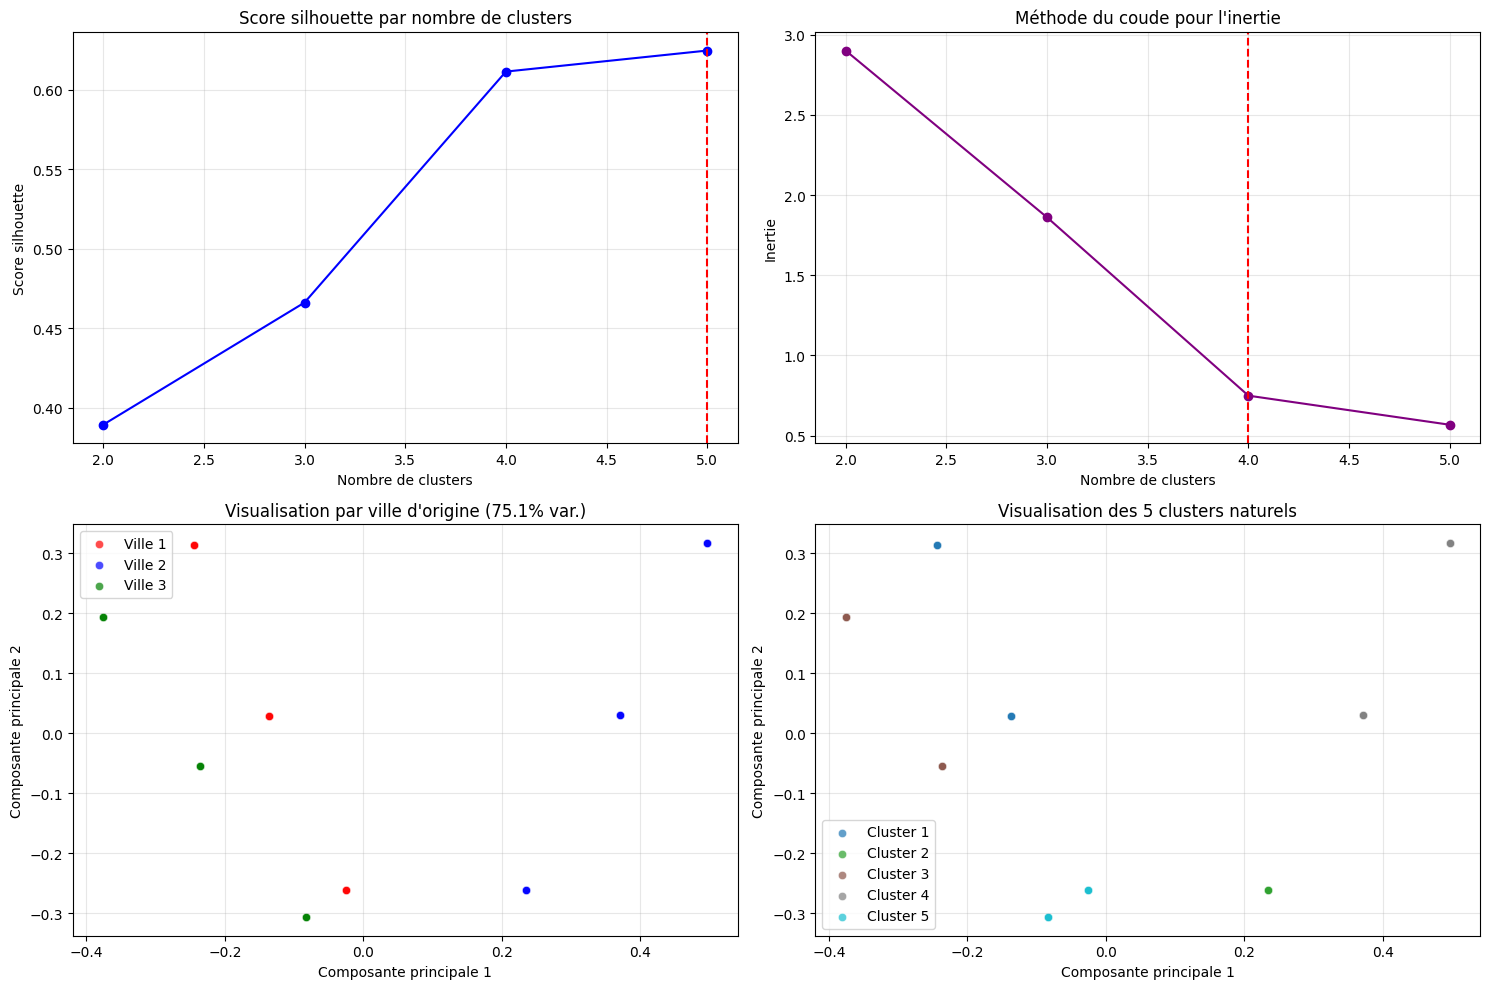

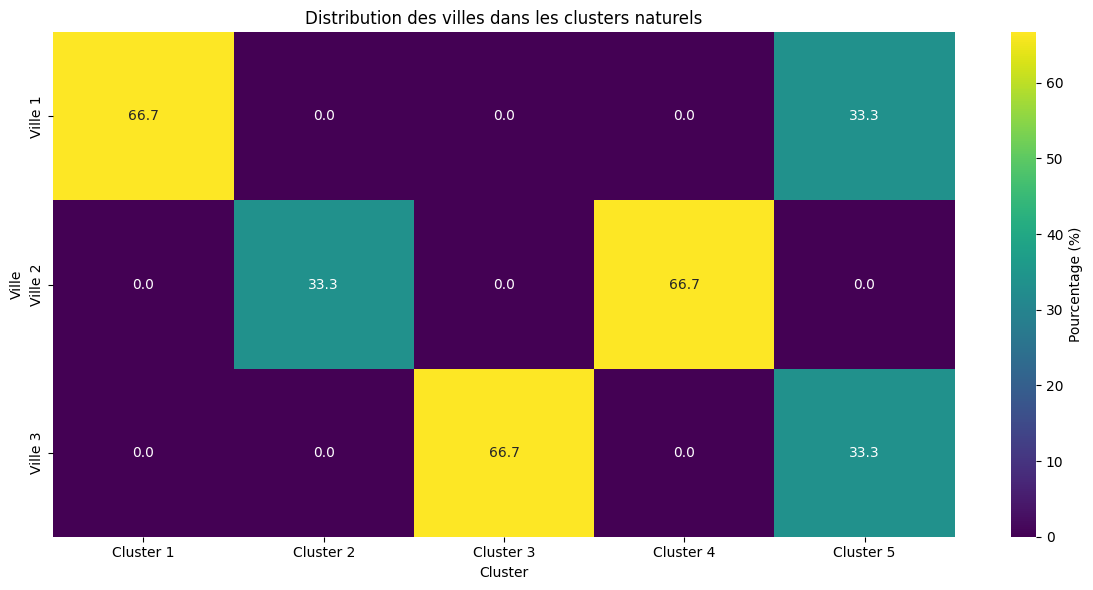

Analyse complète en 32.24 secondes
Ajustement du nombre de clusters de 3 à 5 basé sur l'analyse
Structure des données pour le client 0:
Type: <class 'list'>
Forme de X: (8, 8751, 10), Forme de Y: (10, 8751, 1)
Structure des données pour le client 1:
Type: <class 'list'>
Forme de X: (8, 8775, 10), Forme de Y: (10, 8775, 1)
Structure des données pour le client 2:
Type: <class 'list'>
Forme de X: (8, 8751, 10), Forme de Y: (10, 8751, 1)
Forme finale de X_test: (8, 15, 10), Y_test: (10, 15, 1)

=== Cycle de communication 1/3 ===
Phase 1: Initialisation avec FedAvg et création des centres de clusters
Entraînement du client 1/3
Époque 1/3
Loss: -0.1534
Époque 2/3
Loss: -0.2290
Époque 3/3
Loss: -0.3053
Époque 1/3
Loss: -0.1534
Époque 2/3
Loss: -0.2290
Époque 3/3
Loss: -0.3053
Époque 1/3
Loss: -0.1534
Époque 2/3
Loss: -0.2290
Époque 3/3
Loss: -0.3053
Époque 1/3
Loss: -0.1534
Époque 2/3
Loss: -0.2290
Époque 3/3
Loss: -0.3053
Époque 1/3
Loss: -0.1534
Époque 2/3
Loss: -0.2290
Époque 3/3
Loss: -0.

C:\Users\ikram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\ikram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
C:\Users\ikram\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwa

Résultats du cycle 1:
  Méthode proposée - Accuracy: 0.9635, Loss: 0.9283
  FedAvg traditionnel - Accuracy: 0.9635, Loss: 0.9283
  Bande passante traditionnelle: 65.37 KB
  Bande passante proposée: 392.50 KB

=== Cycle de communication 2/3 ===
Phase 2: Mise à jour avec matrices de transition et adaptation des centres
Client 1/3
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Époque 1/3
Loss: -0.3020
Époque 2/3
Loss: -0.3635
Époque 3/3
Loss: -0.4180
Client 2/3
Époque 1/3
Loss: -0.1647
Époque 2/3
Loss: -0.1969
Époque 3/3
Loss: -0.2325
Époque 1/3
Loss: -0.1647
Époque 2/3
Loss: -0.1969
Époque 3/3
Loss: -0.2325
Époque 1/3
Loss: -0.1647
Époque 2/3
Loss: -0.1969
Époque 3/

C:\Users\ikram\AppData\Local\Temp\ipykernel_85916\1522900237.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


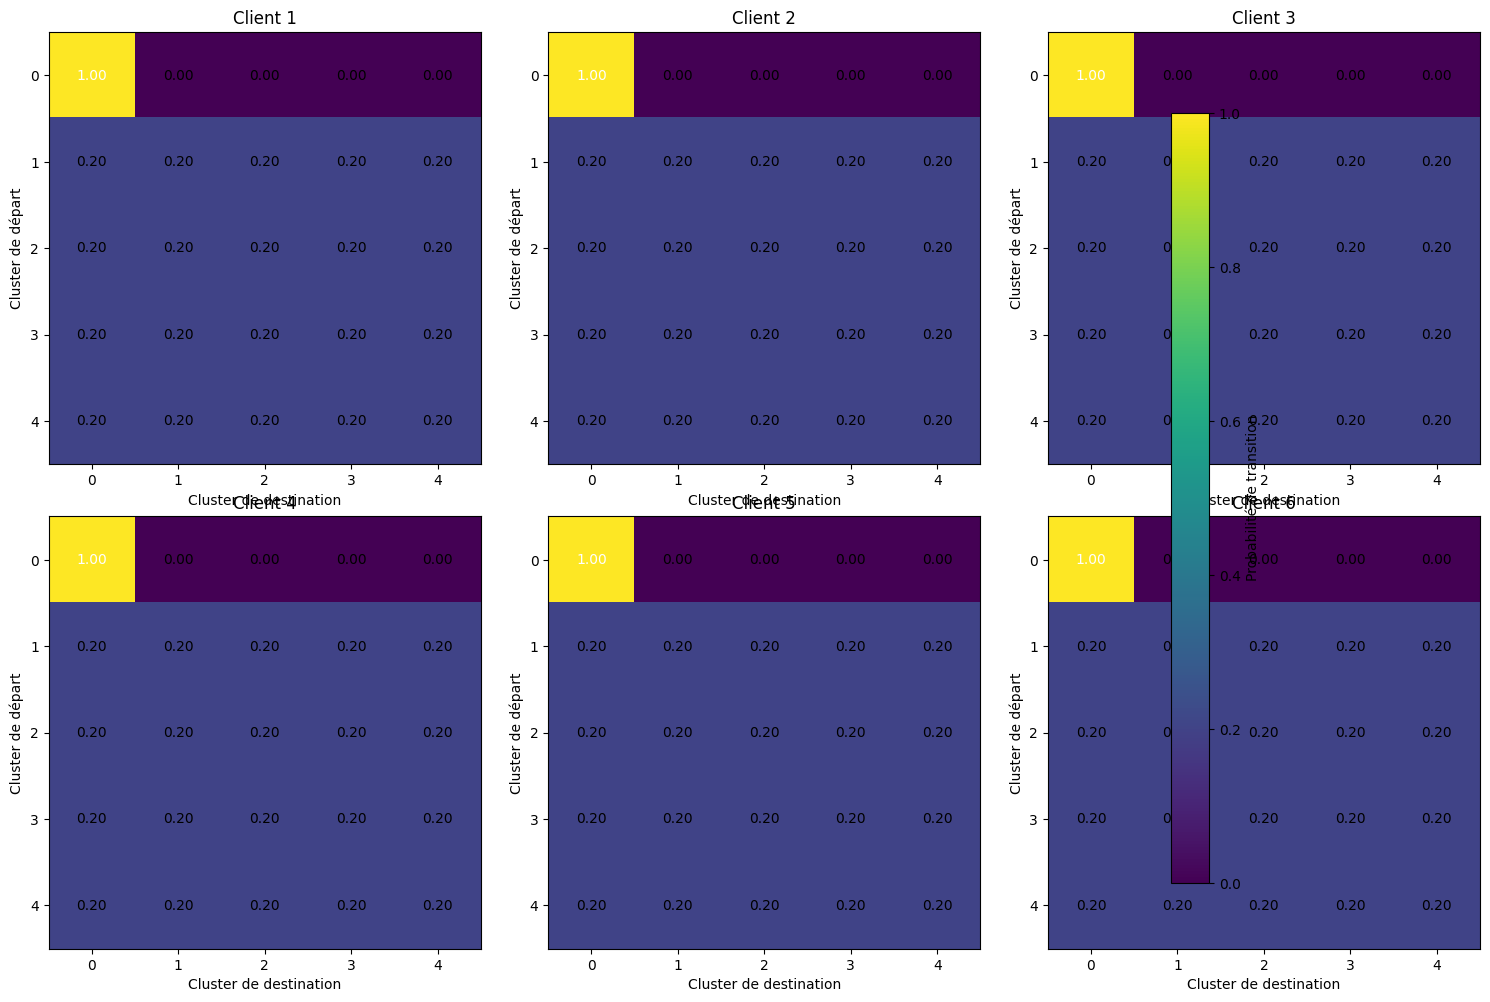


🔍 ANALYSE DE L'ESPACE DES PARAMÈTRES
🔍 ANALYSE SÉCURISÉE DE L'ESPACE DES PARAMÈTRES
Nombre total d'échantillons disponibles: 45

1. Visualisation PCA...
=== Visualisation de la distribution des paramètres LSTM ===
Client 1: 5 seeds avec 3 époques chacune
Client 2: 5 seeds avec 3 époques chacune
Client 3: 5 seeds avec 3 époques chacune
Forme du dataset: (45, 5578)
Nombre total de paramètres par point: 5578
Nombre total de points: 45
Nombre de clusters ajusté: 3
Réduction de dimensionnalité avec PCA...
Variance expliquée: PC1=0.663, PC2=0.202


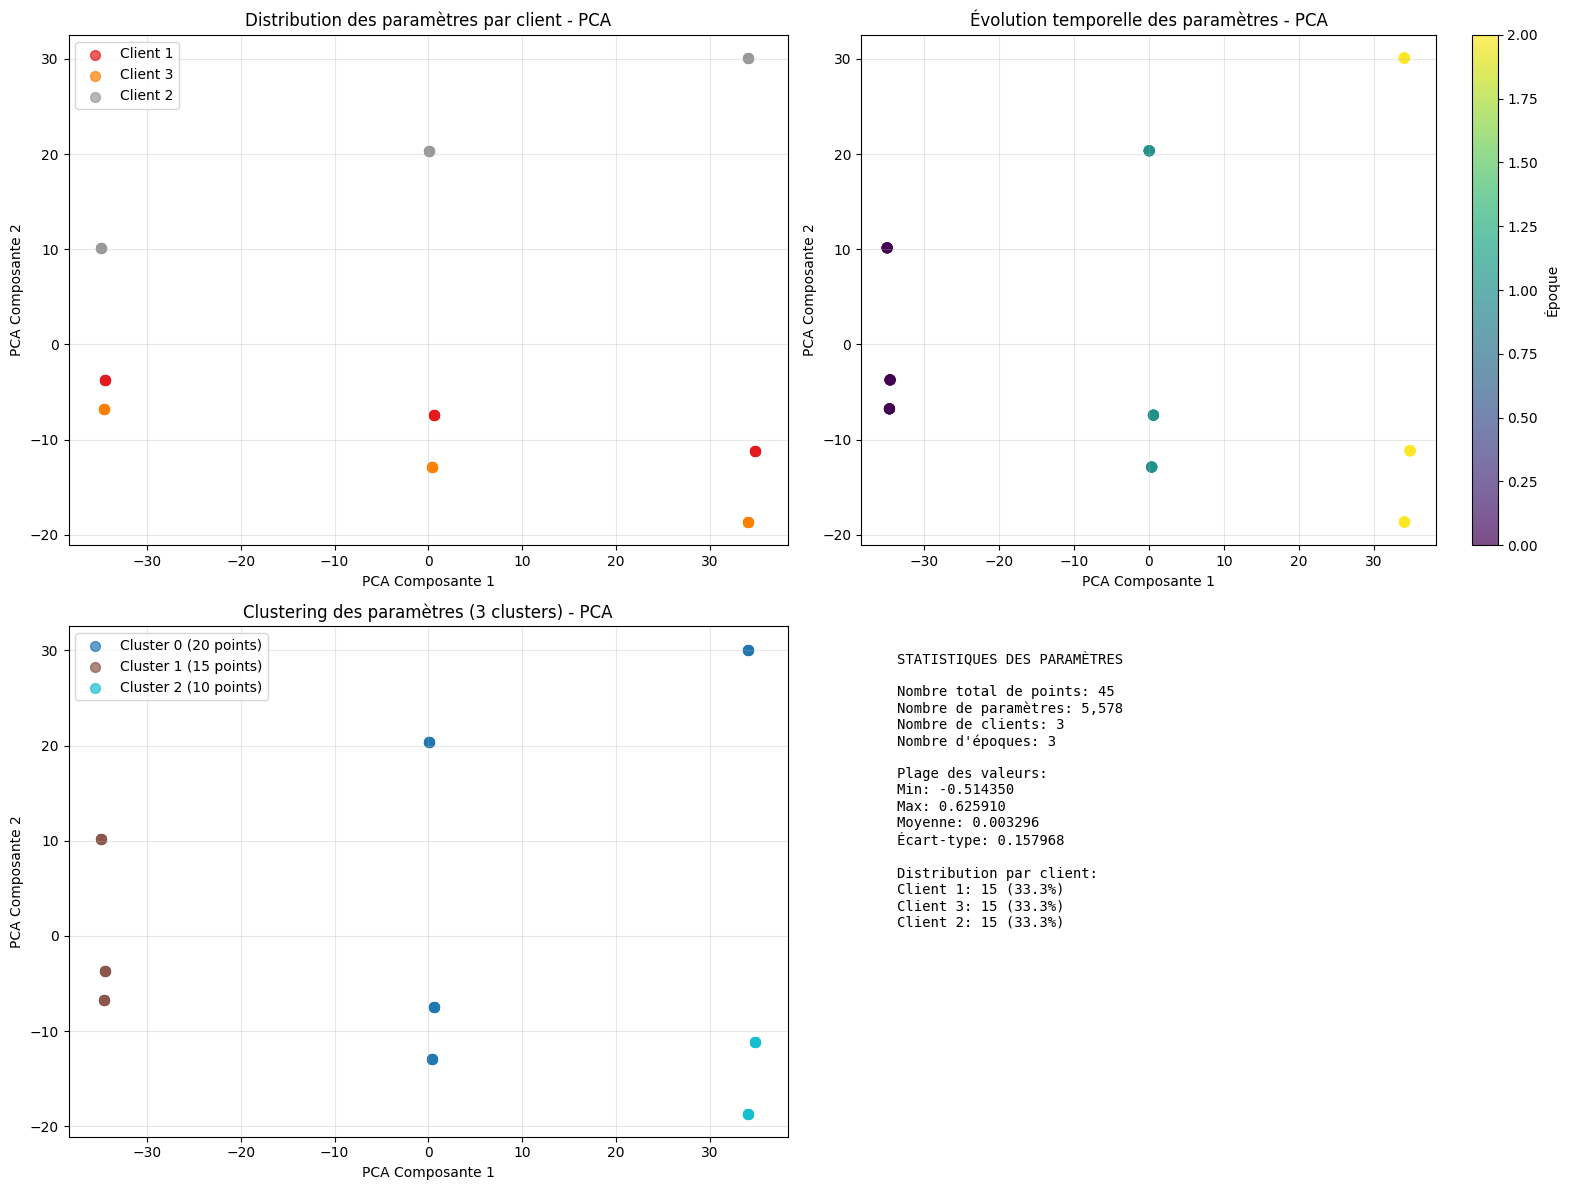


=== Statistiques de la distribution ===
Nombre total de points: 45
Dimensions originales: 5,578
Plage des valeurs: [-0.514350, 0.625910]

2. Analyse de la séparabilité des clusters...
=== Analyse de la séparabilité des clusters ===
Nombre d'échantillons: 45
Plage de clusters testée: [2, 3, 4, 5, 6, 7]
⚠️ Erreur pour 2 clusters: name 'calinski_harabasz_score' is not defined
⚠️ Erreur pour 3 clusters: name 'calinski_harabasz_score' is not defined
⚠️ Erreur pour 4 clusters: name 'calinski_harabasz_score' is not defined
⚠️ Erreur pour 5 clusters: name 'calinski_harabasz_score' is not defined
⚠️ Erreur pour 6 clusters: name 'calinski_harabasz_score' is not defined
⚠️ Erreur pour 7 clusters: name 'calinski_harabasz_score' is not defined


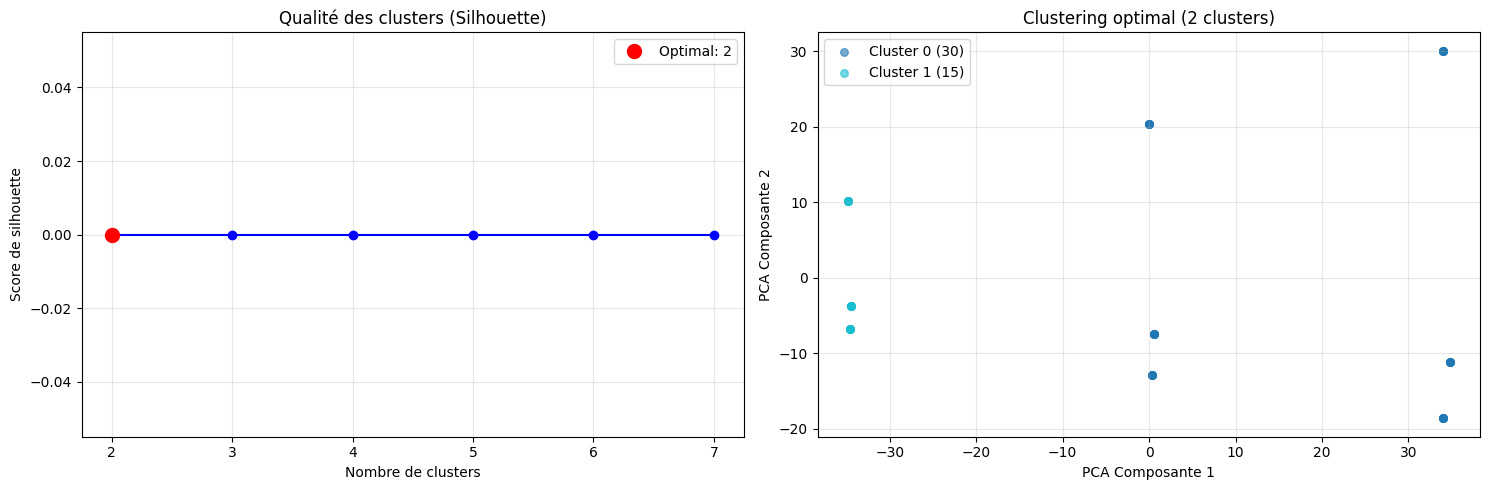


=== Recommandations ===
Meilleur nombre de clusters: 2
Score de silhouette optimal: 0.0000
⚠️  Score de silhouette faible - clusters peu séparés
   → Vos paramètres LSTM forment un nuage compact

✅ Analyse terminée avec succès!
🎯 Ajustement: 5 → 2 clusters
🎯 Utilisation du nombre optimal de clusters: 2

=== Résumé de l'expérience en deux phases avec clusterisation locale ===
Nombre de cycles de communication: 3
Temps total d'exécution: 232.55 secondes
Bande passante traditionnelle totale: 196.10 KB
Bande passante proposée totale: 393.08 KB
Économie de bande passante totale: -100.45%

RÉCAPITULATIF DES PERFORMANCES :
----------------------------------------------------------------------------------------------------
| Cycle | Proposée Acc | FedAvg Acc | Diff Acc (%) | Proposée Loss | FedAvg Loss | Diff Loss (%) |
----------------------------------------------------------------------------------------------------
|     1 |      0.9635 |    0.9635 |       0.00 |       0.9283 |     0.9283

In [ ]:
def main_two_phase():
    """
    Fonction principale pour l'approche en deux phases.
    """
    print("=" * 80)
    print("EXPÉRIENCE FEDERATED LEARNING AVEC APPROCHE EN DEUX PHASES")
    print("=" * 80)

    # Paramètres
    params = {
        "n_clients": 3,            # Nombre de clients
        "n_epochs": 30,             # Nombre d'époques pour l'entraînement local
        "n_clusters": 3,           # Nombre de clusters pour la compression
        "n_a": 32,                 # Dimension cachée
        "n_x": 8,                  # Dimension d'entrée
        "n_y": 10,                  # Nombre de classes
        "batch_size": 32,          # Taille du batch
        "sequence_length": 10,     # Longueur de séquence
        "num_transfer_epochs": 3,  # Époques pour le transfer learning
        "learning_rate": 0.01,     # Taux d'apprentissage
        "n_communication_rounds": 3, # Nombre de cycles de communication
        "use_synthetic_data": False  # Utiliser des données synthétiques
    }


     # Exécuter l'expérience
    results, final_model_proposed, final_model_fedavg = federated_main_two_phase_local(**params)


    # Afficher un tableau récapitulatif des performances
    print("\nRÉCAPITULATIF DES PERFORMANCES :")
    print("-" * 100)
    print("| Cycle | Proposée Acc | FedAvg Acc | Diff Acc (%) | Proposée Loss | FedAvg Loss | Diff Loss (%) |")
    print("-" * 100)

    for result in results:
        cycle = result["cycle"] + 1
        prop_acc = result["proposed_accuracy"]
        fedavg_acc = result["fedavg_accuracy"]
        prop_loss = result["proposed_loss"]
        fedavg_loss = result["fedavg_loss"]

        # Calcul des différences en pourcentage
        if fedavg_acc > 0:
            acc_diff = ((prop_acc - fedavg_acc) / fedavg_acc) * 100
        else:
            acc_diff = float('inf')

        if fedavg_loss > 0:
            loss_diff = ((prop_loss - fedavg_loss) / fedavg_loss) * 100
        else:
            loss_diff = float('inf')

        # Signe pour indiquer si c'est mieux (+) ou moins bien (-)
        acc_sign = "+" if acc_diff > 0 else ""
        loss_sign = "+" if loss_diff > 0 else ""

        print(f"| {cycle:5d} | {prop_acc:11.4f} | {fedavg_acc:9.4f} | {acc_sign}{acc_diff:10.2f} | {prop_loss:12.4f} | {fedavg_loss:10.4f} | {loss_sign}{loss_diff:11.2f} |")

    print("-" * 100)

    # Afficher un récapitulatif des économies de bande passante
    print("\nRÉCAPITULATIF DES ÉCONOMIES DE BANDE PASSANTE :")
    print("-" * 80)
    print("| Cycle | Traditionnelle (KB) | Proposée (KB) | Économie (%) |")
    print("-" * 80)

    total_trad = 0
    total_prop = 0

    for result in results:
        cycle = result["cycle"] + 1
        trad_kb = result["traditional_bandwidth"] / 1024
        prop_kb = result["proposed_bandwidth"] / 1024

        if cycle > 1:  # Phase 2
            saving = (1 - prop_kb/trad_kb) * 100
            print(f"| {cycle:5d} | {trad_kb:18.2f} | {prop_kb:13.2f} | {saving:11.2f} |")
        else:  # Phase 1
            print(f"| {cycle:5d} | {trad_kb:18.2f} | {prop_kb:13.2f} | {'N/A':11s} |")

        total_trad += result["traditional_bandwidth"]
        total_prop += result["proposed_bandwidth"]

    print("-" * 80)

    # Économie totale
    total_trad_kb = total_trad / 1024
    total_prop_kb = total_prop / 1024
    total_saving = (1 - total_prop/total_trad) * 100

    print(f"| Total | {total_trad_kb:18.2f} | {total_prop_kb:13.2f} | {total_saving:11.2f} |")
    print("-" * 80)

    # Conclusion
    print("\nCONCLUSION:")
    avg_acc_diff = sum([(r["proposed_accuracy"] - r["fedavg_accuracy"]) / r["fedavg_accuracy"] * 100 if r["fedavg_accuracy"] > 0 else 0 for r in results]) / len(results)
    avg_loss_diff = sum([(r["proposed_loss"] - r["fedavg_loss"]) / r["fedavg_loss"] * 100 if r["fedavg_loss"] > 0 else 0 for r in results]) / len(results)

    print(f"Différence moyenne de précision: {avg_acc_diff:.2f}%")
    print(f"Différence moyenne de perte: {avg_loss_diff:.2f}%")
    print(f"Économie moyenne de bande passante (cycles 2-3): {total_saving:.2f}%")

    if avg_acc_diff > -1 and total_saving > 50:  # Seuils arbitraires pour la conclusion
        print("VERDICT: La méthode proposée permet d'économiser significativement de la bande passante tout en maintenant des performances comparables à FedAvg.")
    elif avg_acc_diff < -5:
        print("VERDICT: La méthode proposée économise de la bande passante mais au détriment d'une baisse notable des performances.")
    else:
        print("VERDICT: Compromis modéré entre économie de bande passante et performances.")

    return results, final_model_proposed, final_model_fedavg

if __name__ == "__main__":
    main_two_phase()